In [1]:
import torch
from torch.utils.data import TensorDataset,DataLoader,Dataset
from torch import nn

import altair as alt
import logomaker
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import random
random.seed(7) #10



import utils as u

In [2]:
def load_data(
        upstream_region_file,
        data_mat_file, 
        sample2cond_file, 
        sample_file, 
        condition_file,
        coded_meta_file
        ):
    '''
    Wrapper function to load data from files into relavent objects
    '''
    # load upstream seq regions
    seqs = u.load_promoter_seqs(upstream_region_file)
    loc2seq = dict([(x,z) for (x,y,z) in seqs])
    
    # load TPM data
    tpm_df = pd.read_csv(data_mat_file,sep='\t').fillna('')

    
    # load mapping from sample to condition
    with open(sample2cond_file,'r') as f:
        sample2condition = dict(x.strip().split() for x in f.readlines())

    
    # load sample to include file
    if sample_file:
        with open(sample_file,'r') as f:
            samples = list(x.strip() for x in f.readlines())
    # if none provided, just use all the samples from the sample2condition dict
    else: 
        samples = list(sample2condition.keys())

        
    # load the conditions to include file
    if condition_file:
        with open(condition_file,'r') as f:
            conditions = list(x.strip() for x in f.readlines())
    # if none provided, just use all the conditions
    else:
        conditions = list(set([sample2condition[x] for x in sample2condition]))

    # load coded metadata file
    meta_df = pd.read_csv(coded_meta_file,sep='\t')
    meta_df['sample'] = meta_df['#sample']+'_tpm'

    return loc2seq, tpm_df, sample2condition, samples, conditions, meta_df

In [3]:
upstream_region_file = 'all_seq_info/all_loci_upstream_regions_w100_min20.fa'
data_mat_file = 'data/extract_TPM_counts.tsv'
sample2cond_file = 'data/sample2condition.txt'
sample_file = None
condition_file = 'data/conditions_to_include.txt'
coded_meta_file = 'data/5G_exp_metadata_coded.tsv'

COND_COLS = ['carbon_source','oxygen_level','nitrate_level',
             'copper_level','lanthanum_level','growth_rate',
             'growth_mode']


loc2seq, tpm_df, sample2condition, samples, conditions, meta_df = load_data(
    upstream_region_file,
    data_mat_file, 
    sample2cond_file, 
    sample_file, 
    condition_file,
    coded_meta_file
)

In [4]:
tpm_df.head()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...,1318,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...,1102,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...,1081,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...,2416,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
4,EQU24_RS00025,hypothetical protein,CDS,,NZ_CP035467.1,6825,7062,Derived by automated computational analysis us...,VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...,238,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192


In [5]:
print(np.mean(tpm_df['5GB1_pA9_red_tpm']))
print(np.mean(tpm_df['5GB1C-5G-La-BR1_tpm']))

237.36055067647757
237.3605506764776


In [6]:
locus2info = u.make_info_dict(tpm_df)
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [7]:
df_means = u.get_gene_means_by_condition(tpm_df,samples,sample2condition)

In [8]:
df_means

locus_tag,exp_condition,EQU24_RS00005,EQU24_RS00010,EQU24_RS00015,EQU24_RS00020,EQU24_RS00025,EQU24_RS00030,EQU24_RS00035,EQU24_RS00040,EQU24_RS00045,...,EQU24_RS22110,EQU24_RS22115,EQU24_RS22120,EQU24_RS22125,EQU24_RS22130,EQU24_RS22135,EQU24_RS22140,EQU24_RS22145,EQU24_RS22150,EQU24_RS22155
0,LanzaTech,25.626702,55.711920,11.804042,76.880335,43.737438,27.940983,35.296053,25.926725,23.461781,...,7420.641716,16.014544,15.947067,16.286482,9.514666,46.013885,354.315359,157.364073,571.458102,613.084675
1,MeOH,23.323155,18.905775,18.443916,18.257805,16.950643,12.367795,43.805536,9.660950,7.292145,...,1298.247682,15.614619,20.198066,25.994364,20.950234,28.709983,93.606437,161.518124,496.980651,280.334047
2,NO3_lowO2_slow_growth,32.040358,43.646760,21.341623,62.257687,41.674925,31.911455,57.839768,16.875694,14.916147,...,6497.858109,26.263485,28.935133,23.515245,26.422667,35.157264,178.986199,164.073806,433.428735,493.885115
3,NoCu,44.338687,59.619360,28.258717,56.808319,49.829406,38.384652,81.520362,40.491969,36.566500,...,8345.775345,43.055124,34.370565,44.409579,34.591933,65.329879,253.598495,273.274694,731.042190,1087.611126
4,NoLanthanum,33.434023,43.679839,23.162675,57.287047,42.357072,41.931657,102.503601,30.216787,19.452312,...,5085.627409,16.413284,35.578138,44.613117,43.191743,21.917260,109.773330,67.267718,211.565175,328.933746
5,WT_control,34.988452,38.272163,15.495930,54.855025,35.396786,26.817623,59.558466,24.797995,27.925137,...,4939.367129,18.248719,21.027514,31.490596,45.810743,36.195898,172.298263,181.468991,403.551659,648.122601
6,WithLanthanum,35.452185,41.782237,20.634554,57.120166,34.248335,46.191637,110.711781,31.803805,19.428086,...,3942.947792,15.962203,34.308829,49.206725,39.990662,21.210809,98.090610,73.106973,194.379586,319.988959
7,aa3_KO,26.849583,45.489035,11.962099,55.846659,33.097353,28.718155,50.249664,21.490715,24.790508,...,5355.094603,16.236806,20.836285,28.298842,40.627394,30.065630,181.790564,153.928317,376.664997,657.228922
8,crotonic_acid,38.684021,52.507256,33.132559,77.849631,49.837247,37.332021,69.675355,32.001867,35.856260,...,8680.904376,42.175374,47.879804,58.961083,43.069352,81.481463,365.899345,315.553709,614.920997,676.638496
9,highCu,47.851477,79.099490,33.524043,73.320408,48.652214,33.976359,92.989818,51.940784,50.360579,...,8132.537467,48.884308,35.598730,46.099300,30.115207,89.700150,342.971435,386.483127,1021.443762,1692.391154


In [14]:
df_meansT.reset_index()

exp_condition,locus_tag,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
0,EQU24_RS00005,25.636702,23.333155,32.050358,44.348687,33.444023,34.998452,35.462185,26.859583,38.694021,47.861477,64.784508,30.829331,42.973556,35.736190,15.244857,44.920897,36.397225,52.045884,20.472977
1,EQU24_RS00010,55.721920,18.915775,43.656760,59.629360,43.689839,38.282163,41.792237,45.499035,52.517256,79.109490,99.002970,33.532522,61.209155,43.159066,22.837232,65.011074,48.969456,59.991257,20.763038
2,EQU24_RS00015,11.814042,18.453916,21.351623,28.268717,23.172675,15.505930,20.644554,11.972099,33.142559,33.534043,44.856281,18.491160,28.828713,27.325800,10.091116,29.419165,17.064284,33.943076,12.254885
3,EQU24_RS00020,76.890335,18.267805,62.267687,56.818319,57.297047,54.865025,57.130166,55.856659,77.859631,73.330408,78.997757,42.963648,61.573321,48.976066,23.888176,65.393162,65.160826,71.052489,29.612255
4,EQU24_RS00025,43.747438,16.960643,41.684925,49.839406,42.367072,35.406786,34.258335,33.107353,49.847247,48.662214,77.842263,31.643505,50.966799,33.463183,18.059006,48.729958,44.713674,48.648085,29.504437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4208,EQU24_RS22135,46.023885,28.719983,35.167264,65.339879,21.927260,36.205898,21.220809,30.075630,81.491463,89.710150,52.033315,60.397912,66.743497,72.207950,15.818300,84.626668,30.158381,89.974638,31.295152
4209,EQU24_RS22140,354.325359,93.616437,178.996199,253.608495,109.783330,172.308263,98.100610,181.800564,365.909345,342.981435,220.196691,226.909132,293.599291,334.033049,70.221069,340.031564,167.380791,431.225393,114.118228
4210,EQU24_RS22145,157.374073,161.528124,164.083806,273.284694,67.277718,181.478991,73.116973,153.938317,315.563709,386.493127,244.139008,297.029289,313.741841,376.513322,83.988939,377.219038,185.233190,449.945881,119.781566
4211,EQU24_RS22150,571.468102,496.990651,433.438735,731.052190,211.575175,403.561659,194.389586,376.674997,614.930997,1021.453762,505.427610,874.637567,843.607251,1178.068431,194.929125,1060.050784,499.265866,1302.077251,344.152066


In [10]:
df_meansT.describe()

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
count,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.0,4213.000000
mean,0.838421,0.548184,1.340647,2.395192,2.554996,1.030894,2.714340,1.711196,1.200222,0.982319,1.573759,0.729255,2.002331,0.859595,1.097420,1.241152,1.032939,1.0,237.370551
std,0.473642,0.433830,5.507740,27.118579,29.491416,3.001358,28.067679,12.592860,0.897398,0.373285,2.317138,0.282127,19.338299,0.484331,8.473236,5.638716,2.165846,0.0,5629.014009
min,0.024641,0.042991,0.099171,0.105697,0.027842,0.099723,0.020856,0.000202,0.001391,0.100409,0.135558,0.030596,0.105697,0.182536,0.012498,0.105697,0.012234,1.0,0.010000
25%,0.540334,0.360042,0.652532,0.802853,0.755140,0.519244,0.690695,0.511115,0.890134,0.820457,0.936547,0.573320,0.771607,0.733010,0.237854,0.751042,0.548939,1.0,16.357295
50%,0.769706,0.483823,0.849939,0.968268,1.143256,0.681924,1.089658,0.692215,1.079499,0.947706,1.253853,0.688813,0.915019,0.807453,0.346898,0.870560,0.788186,1.0,33.022486
75%,1.018268,0.647136,1.109000,1.162432,1.720748,0.945165,1.722037,0.969387,1.312195,1.082924,1.701097,0.833474,1.070163,0.900136,0.510621,1.000000,1.126483,1.0,66.810771
max,8.339786,16.932032,214.918823,1082.385111,1736.807856,105.882369,1626.001275,465.446750,22.755178,10.709693,67.563010,5.779289,725.628885,14.869014,274.120680,257.534695,128.181235,1.0,259438.757124


In [46]:
psuedo_count = 0.01
df_meansT = df_means.set_index("exp_condition").T + psuedo_count
df_means_lr = pd.DataFrame()
df_means_lr['locus_tag'] = df_meansT.reset_index()['locus_tag']
df_means_lr = df_means_lr.set_index('locus_tag')

In [47]:
# convert to LOG RATIO version
denom = 'lowCu' # 'uMax'
for cond in df_meansT.columns:
    print(cond)
    co = df_meansT[cond].values
    de = df_meansT[denom].values
    #print(co)
    #print(de)
    #print(co/de)
    
    df_means_lr[cond] = df_meansT[cond]/df_meansT[denom]
    #display(df_means_lr)

LanzaTech
MeOH
NO3_lowO2_slow_growth
NoCu
NoLanthanum
WT_control
WithLanthanum
aa3_KO
crotonic_acid
highCu
highO2_slow_growth
lowCH4
lowCu
lowO2_fast_growth
lowO2_slow_growth
medCu
slow_growth
uMax
unknown


In [48]:
df_means_lr

,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,0.596569,0.542965,0.745816,1.031999,0.778247,0.814418,0.825209,0.625026,0.900415,1.113743,1.507544,0.717402,1.0,0.831586,0.354750,1.045315,0.846968,1.211114,0.476409
EQU24_RS00010,0.910353,0.309035,0.713239,0.974190,0.713779,0.625432,0.682778,0.743337,0.857997,1.292445,1.617454,0.547835,1.0,0.705108,0.373102,1.062114,0.800035,0.980103,0.339215
EQU24_RS00015,0.409801,0.640123,0.740637,0.980575,0.803805,0.537864,0.716111,0.415284,1.149637,1.163217,1.555958,0.641415,1.0,0.947867,0.350037,1.020481,0.591920,1.177405,0.425093
EQU24_RS00020,1.248761,0.296684,1.011277,0.922775,0.930550,0.891052,0.927840,0.907157,1.264503,1.190944,1.282987,0.697764,1.0,0.795410,0.387963,1.062037,1.058264,1.153949,0.480927
EQU24_RS00025,0.858352,0.332778,0.817884,0.977880,0.831268,0.694703,0.672170,0.649587,0.978034,0.954783,1.527313,0.620865,1.0,0.656568,0.354329,0.956112,0.877310,0.954505,0.578895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,0.689564,0.430304,0.526902,0.978970,0.328530,0.542463,0.317946,0.450615,1.220965,1.344103,0.779601,0.904926,1.0,1.081872,0.237001,1.267939,0.451855,1.348066,0.468887
EQU24_RS22140,1.206833,0.318858,0.609662,0.863791,0.373922,0.586882,0.334131,0.619213,1.246288,1.168196,0.749991,0.772853,1.0,1.137717,0.239173,1.158148,0.570099,1.468755,0.388687
EQU24_RS22145,0.501604,0.514844,0.522990,0.871050,0.214437,0.578434,0.233048,0.490653,1.005807,1.231883,0.778153,0.946732,1.0,1.200074,0.267701,1.202323,0.590400,1.434128,0.381784


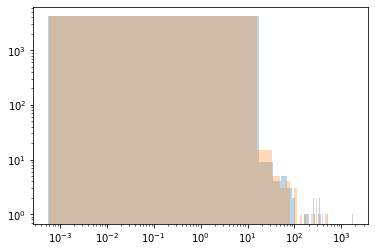

In [49]:
plt.hist(df_means_lr['NoLanthanum'],bins=100,alpha=0.3)
plt.hist(df_means_lr['WithLanthanum'],bins=100,alpha=0.3)
plt.xscale('log')
plt.yscale('log')

In [51]:
# check a quick histogram of log ratio data
df_meansT_melt = pd.melt(df_meansT.reset_index(), id_vars=['locus_tag'],var_name="exp_condition",value_name='tpm')
df_meansT_melt

,locus_tag,exp_condition,tpm
0,EQU24_RS00005,LanzaTech,25.636702
1,EQU24_RS00010,LanzaTech,55.721920
2,EQU24_RS00015,LanzaTech,11.814042
3,EQU24_RS00020,LanzaTech,76.890335
4,EQU24_RS00025,LanzaTech,43.747438
...,...,...,...
80042,EQU24_RS22135,unknown,31.295152
80043,EQU24_RS22140,unknown,114.118228
80044,EQU24_RS22145,unknown,119.781566
80045,EQU24_RS22150,unknown,344.152066


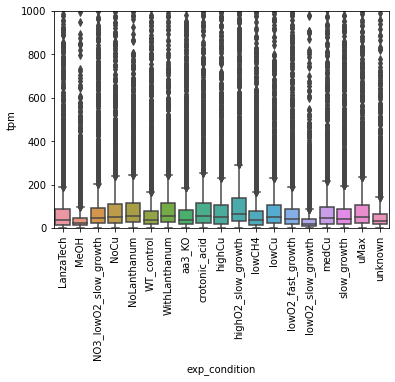

In [54]:
sns.boxplot(data=df_meansT_melt,x="exp_condition",y="tpm")
plt.ylim(-1,1000)
plt.xticks(rotation=90)
plt.show()

In [55]:
df_means_lr.describe()

,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
count,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.0,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000,4213.000000
mean,0.887097,0.589858,1.358282,1.063713,3.038686,1.071895,3.065054,1.660124,1.319083,1.034718,1.524628,0.784137,1.0,0.962937,0.908491,0.953018,1.021313,1.133898,1.043154
std,0.480001,0.388680,4.287524,0.143949,32.409226,3.170809,31.199823,9.079455,1.572276,0.258027,1.248748,0.288714,0.0,0.704313,5.139792,0.170892,3.103261,0.447698,5.223620
min,0.001145,0.000300,0.002136,0.206102,0.000565,0.000502,0.000576,0.000240,0.000959,0.003245,0.001903,0.000667,1.0,0.000885,0.001301,0.148685,0.002110,0.001378,0.000766
25%,0.598588,0.374218,0.736044,0.993970,0.849713,0.603882,0.783506,0.601640,0.956901,0.923944,1.085022,0.647429,1.0,0.735547,0.282983,0.853575,0.661419,0.934437,0.481020
50%,0.836511,0.522346,0.921209,1.058517,1.259046,0.751144,1.202617,0.751631,1.181760,1.036913,1.386503,0.766503,1.0,0.889422,0.372608,0.939035,0.859470,1.092873,0.652734
75%,1.098704,0.725935,1.139647,1.130853,1.773027,0.953362,1.773133,0.971677,1.438347,1.168131,1.721866,0.894046,1.0,1.073096,0.492095,1.039091,1.111306,1.295996,0.960579
max,8.644833,7.967217,165.528942,2.536111,1736.807856,163.909869,1626.001275,231.527137,56.922213,3.302012,40.973771,6.539209,1.0,18.832476,126.875010,2.364316,198.429349,9.461028,199.742704


In [56]:
df_means_lr.T[['EQU24_RS19315']]

locus_tag,EQU24_RS19315
LanzaTech,2.964420
MeOH,0.529959
NO3_lowO2_slow_growth,1.914830
NoCu,0.763595
NoLanthanum,1.887634
WT_control,1.904358
WithLanthanum,1.721252
aa3_KO,2.265714
crotonic_acid,1.371876
highCu,1.434399


In [57]:
# filter to only the copper conditions
cu_conds = ['NoCu','lowCu','medCu','highCu']

#df_means_cu = df_means_lr[df_means_lr.index.isin(cu_conds)]
df_means_cu = df_means_lr[cu_conds]
df_means_cu

,NoCu,lowCu,medCu,highCu
locus_tag,,,,
EQU24_RS00005,1.031999,1.0,1.045315,1.113743
EQU24_RS00010,0.974190,1.0,1.062114,1.292445
EQU24_RS00015,0.980575,1.0,1.020481,1.163217
EQU24_RS00020,0.922775,1.0,1.062037,1.190944
EQU24_RS00025,0.977880,1.0,0.956112,0.954783
...,...,...,...,...
EQU24_RS22135,0.978970,1.0,1.267939,1.344103
EQU24_RS22140,0.863791,1.0,1.158148,1.168196
EQU24_RS22145,0.871050,1.0,1.202323,1.231883


In [58]:
# transpose to get genes as examples again and add upstream region
XYdf = df_means_cu.reset_index()
XYdf['upstream_region'] = XYdf['locus_tag'].apply(lambda x: loc2seq[x])
XYdf = XYdf[['locus_tag','upstream_region']+cu_conds]

XYdf

,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,1.031999,1.0,1.045315,1.113743
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,0.974190,1.0,1.062114,1.292445
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,0.980575,1.0,1.020481,1.163217
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,0.922775,1.0,1.062037,1.190944
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,0.977880,1.0,0.956112,0.954783
...,...,...,...,...,...,...
4208,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,0.978970,1.0,1.267939,1.344103
4209,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,0.863791,1.0,1.158148,1.168196
4210,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,0.871050,1.0,1.202323,1.231883
4211,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,0.866579,1.0,1.256569,1.210817


In [59]:
loc2seq["EQU24_RS19315"]

'GCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA'

In [60]:
class MultiTaskDataset(Dataset):
    def __init__(self,df):
        self.loci = list(df['locus_tag'])
        self.seqs = list(df['upstream_region'])
        self.seq_len = len(self.seqs[0])
    
        self.nocu_labels = list(df['NoCu'])
        self.lowcu_labels = list(df['lowCu'])
        self.medcu_labels = list(df['medCu'])
        self.highcu_labels = list(df['highCu'])
        
    def __len__(self): return len(self.loci)
    
    def __getitem__(self,idx):
        seq = torch.tensor(u.one_hot_encode(self.seqs[idx]))
        
        nocu = torch.tensor(float(self.nocu_labels[idx]))
        lowcu = torch.tensor(float(self.lowcu_labels[idx]))
        medcu = torch.tensor(float(self.medcu_labels[idx]))
        highcu = torch.tensor(float(self.highcu_labels[idx]))
        
        return seq, (nocu, lowcu, medcu, highcu)
        

In [61]:
def quick_load_and_split_input(df, split_frac=0.8, verbose=False):
    '''
    Given a df, randomly split between
    train and test. Not a formal train/test split, just a quick n dirty version.
    
    '''

    # train test split
    idxs = list(range(df.shape[0]))
    random.shuffle(idxs)

    split = int(len(idxs)*split_frac)
    train_idxs = idxs[:split]
    test_idxs = idxs[split:]
    
    # split df and convert to tensors
    train_df = df[df.index.isin(train_idxs)]
    test_df = df[df.index.isin(test_idxs)]
        
    return train_df, test_df


def build_dataloaders(df,batch_size=32):
    # train test split
    train_df, test_df = quick_load_and_split_input(df)
    
    # put into dataloader object
    train_ds = MultiTaskDataset(train_df)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    
    test_ds = MultiTaskDataset(test_df)
    test_dl = DataLoader(test_ds, batch_size=batch_size * 2)
    
    return train_dl, test_dl,train_df,test_df

In [62]:
# did this actually work???
train_dl, test_dl,train_df, test_df = build_dataloaders(XYdf)

In [63]:
NOCU_IDX=0
LOWCU_IDX=1
MEDCU_IDX=2
HIGHCU_IDX=3

class DNA_Linear_Multi(nn.Module):
    def __init__(self,seq_len,h1_size,h2_size):
        super().__init__()
        self.seq_len = seq_len
        # some arbitrary arch of a few linear layers
        self.lin_share = nn.Sequential(
            nn.Linear(4*seq_len, h1_size),
            nn.ReLU(inplace=True),
            nn.Linear(h1_size, h2_size),
            nn.ReLU(inplace=True)
        )
        
        # define the multi task objectives?
        self.nocu_obj   = nn.Linear(h2_size,1)
        self.lowcu_obj  = nn.Linear(h2_size,1)
        self.medcu_obj  = nn.Linear(h2_size,1)
        self.highcu_obj = nn.Linear(h2_size,1)
        
        

    def forward(self, xb):
        # reshape to flatten sequence dimension
        xb = xb.view(xb.shape[0],self.seq_len*4)

        out = self.lin_share(xb)
        
        out_nocu = self.nocu_obj(out)
        out_lowcu = self.lowcu_obj(out)
        out_medcu = self.medcu_obj(out)
        out_highcu = self.highcu_obj(out)
        
        return [out_nocu, out_lowcu, out_medcu, out_highcu]
    


In [64]:
def loss_batch_multi(model, loss_func, xb, yb, opt=None,verbose=None):
    '''
    Apply loss function to a batch of inputs. If no optimizer
    is provided, skip the back prop step.
    '''
    nocu_target = yb[0].unsqueeze(1).float()
    lowcu_target = yb[1].unsqueeze(1).float()
    medcu_target = yb[2].unsqueeze(1).float()
    highcu_target = yb[3].unsqueeze(1).float()
    # need unsqueeze otherwise dimension mismatch? [32] vs [32,1]

    
    #loss = loss_func(model(xb.float()), yb.float())
    # yb is a list of tensors... what should it be?
    # how to adapt loss for multi-task?
    #print("yb[0]:", yb[0])
    
    # try looping through ybs?
    res = model(xb.float()) # get predictions? returns list
    
    loss_nocu = loss_func(res[0], nocu_target)
    loss_lowcu = loss_func(res[1], lowcu_target)
    loss_medcu = loss_func(res[2], medcu_target)
    loss_highcu = loss_func(res[3], highcu_target)
    
    #loss = sum([loss_nocu, loss_lowcu, loss_medcu, loss_highcu])
    loss = torch.mean(torch.stack([loss_nocu, loss_lowcu, loss_medcu, loss_highcu]))
    
    if verbose:
        print("what is 'loss'?:")
        print(loss_nocu)
        print(loss_lowcu)
        print(loss_medcu)
        print(loss_highcu)
        print("*****")

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    #print("lb returning:",loss.item(), len(xb))
    return loss.item(), len(xb)


def fit_multi(epochs, model, loss_func, opt, train_dl, test_dl):
    '''
    Fit the model params to the training data, eval on unseen data.
    Loop for a number of epochs and keep train of train and val losses 
    along the way
    '''
    # keep track of losses
    train_losses = []    
    val_losses = []
    
    # loops through epochs
    for epoch in range(epochs):
        print('Epoch:',epoch)
        #print("TRAIN")
        model.train()
        ts = []
        ns = []
        # collect train loss; provide opt so backpropo happens
        for xb, yb in train_dl:
            t, n = loss_batch_multi(model, loss_func, xb, yb, opt)
            ts.append(t)
            ns.append(n)
        train_loss = np.sum(np.multiply(ts, ns)) / np.sum(ns)
        train_losses.append(train_loss)
        
        #print("EVAL")
        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                # loop through test batches
                # returns loss calc for test set batch size
                # unzips into two lists
                *[loss_batch_multi(model, loss_func, xb, yb) for xb, yb in test_dl]
                # Note: no opt provided, backprop won't happen
            )
        # Gets average MSE loss across all batches (may be of diff sizes, hence the multiply)
        #print("losses", losses)
        #print("nums", nums)
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)
        val_losses.append(val_loss)

    return train_losses, val_losses

Seq len: 100
Epoch: 0


/home/ewilson6/anaconda3/envs/scrambler/lib/python3.7/site-packages/torch/autograd/__init__.py:149: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448224956/work/c10/cuda/CUDAFunctions.cpp:115.)
  allow_unreachable=True, accumulate_grad=True)  # allow_unreachable flag


0 0.04420242341034212
Epoch: 1
1 0.03355234031358895
Epoch: 2
2 0.03318559339497579
Epoch: 3
3 0.03301985957576923
Epoch: 4
4 0.03253577239833516
Epoch: 5
5 0.03232139127808463
Epoch: 6
6 0.03208773328413389
Epoch: 7
7 0.032022342383021915
Epoch: 8
8 0.03182547436507854
Epoch: 9
9 0.031585271575202016


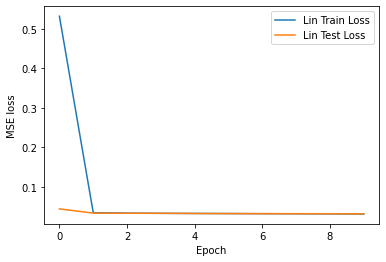

In [65]:
# faster learning rate
h1 = 10
h2 = 10
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.01) 

epochs = 10
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

lin_train_losses, lin_val_losses = fit_multi(
    epochs, 
    multi_lin_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

lin_data_label = list(zip([lin_train_losses,
                           lin_val_losses], 
                          ['Lin Train Loss',
                           'Lin Test Loss']))
u.quick_loss_plot(lin_data_label)

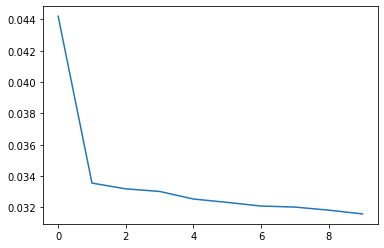

In [66]:
#plt.plot(lin_train_losses[1:])
plt.plot(lin_val_losses)

In [67]:
print(lin_train_losses)
print(lin_val_losses)

[0.5322588921842395, 0.03461279261536697, 0.033360677988486756, 0.03297499725567481, 0.03264733698406984, 0.032351147403349156, 0.03208873780880908, 0.031851202099188854, 0.03166067407021537, 0.031460422874381354]
[0.04420242341034212, 0.03355234031358895, 0.03318559339497579, 0.03301985957576923, 0.03253577239833516, 0.03232139127808463, 0.03208773328413389, 0.032022342383021915, 0.03182547436507854, 0.031585271575202016]


In [47]:
# # slower learning rate
# h1 = 40
# h2 = 20
# multi_lin_model = DNA_Linear_Multi(100, h1,h2)

# loss_func = torch.nn.MSELoss() 
# optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.0001)

# epochs = 50
# train_losses, val_losses = fit(epochs, multi_lin_model, loss_func, optimizer, train_dl, test_dl)

In [48]:
# plt.plot(train_losses,label="train")
# plt.plot(val_losses,label="val")
# plt.legend()
# plt.show()

In [49]:
# plt.plot(val_losses,label="val")
# plt.legend()
# plt.show()

In [68]:
test_df.sort_values('highCu',ascending=False).head(40)

,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
3670,EQU24_RS19310,CTGTAAAAACTATCTCCTGGTCGCTTCTTCTTCATTGAAGAAGCGA...,0.414204,1.0,1.653356,2.250833
3384,EQU24_RS17825,GTTCGACATAACAAAATGGTCGTTGCACAAGTCAATAGCGATATGA...,1.575466,1.0,0.923321,1.991815
2120,EQU24_RS11170,TTTTCTGTGATGGCATTTTCTGTGTAAAGCTGATTCGTTGGTTTGG...,1.319472,1.0,1.420195,1.924505
2276,EQU24_RS11985,TGGCTGCGGCTACGACTGGACCCCGCTCGGATTATTGGCTACGGCA...,1.119666,1.0,1.422316,1.866654
501,EQU24_RS02610,CTGCGAGCTTTGCGTCGACCCTTGCCCGGTCGATTGCATCGTTATG...,1.178651,1.0,1.330248,1.866393
3383,EQU24_RS17820,ATAGACGGCGCCGAGCTCGTCGTGTTGCGCGAAGACGATATTTTGG...,1.443736,1.0,0.999112,1.863940
3634,EQU24_RS19125,AATCGAATAGTTCGTTGGATATAAGTTTGACGTAACTTTTTTTTAA...,1.022751,1.0,1.385982,1.833309
222,EQU24_RS01150,TGATCAATACCAATTATATTTATAGATAACCGATTTTCCATTAGCC...,1.280786,1.0,0.728977,1.757844
2692,EQU24_RS14160,TACGGTGAAAAACTGTTAACGACCGACAATCCGATGACCAATCAAG...,1.016683,1.0,1.543659,1.740707
2287,EQU24_RS12040,GGACGCCTGCCAAATTCAGGCATCGCGCAGCAGTCCGATACTCGAT...,1.074190,1.0,1.033548,1.700615


In [69]:
train_df.sort_values('highCu').head(40)

,locus_tag,upstream_region,NoCu,lowCu,medCu,highCu
1132,EQU24_RS05885,GTCTATGCATTTCCTTTGGTGAATGAGTCTGCAAACGAATAACAAC...,1.491651,1.0,0.179775,0.003245
1133,EQU24_RS05890,CAAAAAGTCGAACCGTTTGAGTTACGAGGCGGGTGCACAGAAAGCC...,1.398414,1.0,0.186609,0.003954
1136,EQU24_RS05905,TTAGCGGAGTGAATTTATTAAGAAGGCTAAATAATCAAAAATGTAA...,1.428564,1.0,0.174732,0.007494
1137,EQU24_RS05910,TGTTCTCTATCGCTGCGATCCGCTAAGGAAGCTGTAGATCATGTGA...,1.347942,1.0,0.169699,0.008282
1139,EQU24_RS05920,TTAGAGATTGCTCCTGTAAATTTTGTTTTCACTCATTGAGCGTAAG...,1.583836,1.0,0.148685,0.009660
1138,EQU24_RS05915,TTGTTCTATGTTCGAATCAATGTAGGGCGCAAAACGGTCTTTAGGG...,1.700784,1.0,0.178972,0.010980
1140,EQU24_RS05925,ACTTTACTTTAGACAGTAAGAGAATTTAGAAAGTAAGAGCGGCTTA...,1.636664,1.0,0.161878,0.011891
3992,EQU24_RS21000,TTTGGCATATTAATTGACACCTATTTATTCCGGTTATTTTATTTTT...,0.998367,1.0,0.638036,0.018600
3993,EQU24_RS21005,TTCCAGGAGCTATCAATGTATCGCGATAAATCAACACGCTAGGCCG...,0.993333,1.0,0.651840,0.023133
131,EQU24_RS00670,GTATGCACTCTTCACGAGACTAGAGTTGAATCCTTCCTCTTTAATG...,2.014028,1.0,0.214787,0.054211


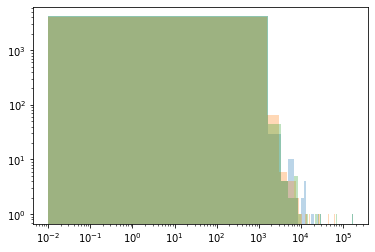

In [71]:
# what's the hist of NoCu vs HighCu vs uMax?
plt.hist(df_meansT['NoCu'],bins=100,alpha=0.3)
plt.hist(df_meansT['highCu'],bins=100,alpha=0.3)
plt.hist(df_meansT['uMax'],bins=100,alpha=0.3)
plt.xscale('log')
plt.yscale('log')

(1000.0, 10000.0)

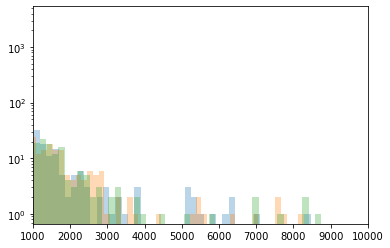

In [100]:
# what's the hist of NoCu vs HighCu vs uMax?
plt.hist(df_means.set_index('exp_condition').T['NoCu'],bins=1000,alpha=0.3)
plt.hist(df_means.set_index('exp_condition').T['highCu'],bins=1000,alpha=0.3)
plt.hist(df_means.set_index('exp_condition').T['uMax'],bins=1000,alpha=0.3)
#plt.xscale('log')
plt.yscale('log')
plt.xlim(1000,10000)

In [90]:
df_means.set_index('exp_condition').T

exp_condition,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,highCu,highO2_slow_growth,lowCH4,lowCu,lowO2_fast_growth,lowO2_slow_growth,medCu,slow_growth,uMax,unknown
locus_tag,,,,,,,,,,,,,,,,,,,
EQU24_RS00005,25.626702,23.323155,32.040358,44.338687,33.434023,34.988452,35.452185,26.849583,38.684021,47.851477,64.774508,30.819331,42.963556,35.726190,15.234857,44.910897,36.387225,52.035884,20.462977
EQU24_RS00010,55.711920,18.905775,43.646760,59.619360,43.679839,38.272163,41.782237,45.489035,52.507256,79.099490,98.992970,33.522522,61.199155,43.149066,22.827232,65.001074,48.959456,59.981257,20.753038
EQU24_RS00015,11.804042,18.443916,21.341623,28.258717,23.162675,15.495930,20.634554,11.962099,33.132559,33.524043,44.846281,18.481160,28.818713,27.315800,10.081116,29.409165,17.054284,33.933076,12.244885
EQU24_RS00020,76.880335,18.257805,62.257687,56.808319,57.287047,54.855025,57.120166,55.846659,77.849631,73.320408,78.987757,42.953648,61.563321,48.966066,23.878176,65.383162,65.150826,71.042489,29.602255
EQU24_RS00025,43.737438,16.950643,41.674925,49.829406,42.357072,35.396786,34.248335,33.097353,49.837247,48.652214,77.832263,31.633505,50.956799,33.453183,18.049006,48.719958,44.703674,48.638085,29.494437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EQU24_RS22135,46.013885,28.709983,35.157264,65.329879,21.917260,36.195898,21.210809,30.065630,81.481463,89.700150,52.023315,60.387912,66.733497,72.197950,15.808300,84.616668,30.148381,89.964638,31.285152
EQU24_RS22140,354.315359,93.606437,178.986199,253.598495,109.773330,172.298263,98.090610,181.790564,365.899345,342.971435,220.186691,226.899132,293.589291,334.023049,70.211069,340.021564,167.370791,431.215393,114.108228
EQU24_RS22145,157.364073,161.518124,164.073806,273.274694,67.267718,181.468991,73.106973,153.928317,315.553709,386.483127,244.129008,297.019289,313.731841,376.503322,83.978939,377.209038,185.223190,449.935881,119.771566


In [72]:
TASKS = {
    0:"NoCu",
    1:"lowCu",
    2:"medCu",
    3:"highCu"
}

def alt_parity_plot_multi(model_name,df, pearson,task):
    chart = alt.Chart(df).mark_circle(opacity=0.2).encode(
        alt.X('pred:Q'),
        alt.Y('truth:Q'),
        alt.Color('task:N'),
        tooltip=['locus_tag:N','gene:N','product:N','type:N']
    ).properties(
        title=f'Model:{model_name} (pearson:{pearson})'
    ).interactive()
    
    chart.save(f'alt_out/parity_plot_{task}_{model_name}.html')
    
def parity_plot_multi(model,df, pearson):
    #plt.scatter(df['pred'].values, df['truth'].values, alpha=0.2)
    sns.scatterplot(data=df,x='pred',y='truth',hue='task',alpha=0.2)
    plt.xlabel("Predicted Score",fontsize=14)
    plt.ylabel("Actual Score",fontsize=14)
    plt.title(f"{model} (pearson:{pearson:.3f})",fontsize=20)
    plt.show()
    
    
def parity_pred_multi(models, genes, oracle,task,alt=True):
    '''Given some sequences, get the model's predictions '''
    dfs = {} # key: model name, value: parity_df
    
    
    for model_name,model in models:
        print(f"Running {model_name}")
        data = []
        for gene in genes:
            dna = loc2seq[gene]
            s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
            actual = oracle[gene]
            preds = [x.item() for x in model(s.float())]
#             print(f"{gene}:{dna}")
#             print(preds)
            
            for i in range(len(preds)):
                data.append((gene,actual[i], preds[i],TASKS[i]))

        df = pd.DataFrame(data, columns=['locus_tag','truth','pred','task'])
        pearson = df['truth'].corr(df['pred'])
        df['gene'] = df['locus_tag'].apply(lambda x: locus2info[x]['gene'])
        df['product'] = df['locus_tag'].apply(lambda x: locus2info[x]['product'])
        df['type'] = df['locus_tag'].apply(lambda x: locus2info[x]['type'])
        dfs[model_name] = (pearson,df)
        
        #plot parity plot
        if alt: # make an altair plot
            alt_parity_plot_multi(model_name, df, pearson,task)
        parity_plot_multi(model_name, df, pearson)

    return dfs

In [73]:
locus2info['EQU24_RS19315']

{'gene': 'pmoC',
 'product': 'methane monooxygenase/ammonia monooxygenase subunit C',
 'type': 'CDS'}

In [74]:
# oracle_multi = dict([(a,
#                       {"noCu":b,
#                        "lowCu":c,
#                        "medCu":d,
#                        "highCu":e}) for a,b,c,d,e in XYdf[['locus_tag','NoCu','lowCu','medCu','highCu']].values])


oracle_multi = dict([(a,(b,c,d,e)) for a,b,c,d,e in XYdf[['locus_tag','NoCu','lowCu','medCu','highCu']].values])

In [75]:
oracle_multi['EQU24_RS12525']

(0.9568600180088729, 1.0, 0.9652824742932661, 0.8670981283626296)

Running LinearDeep


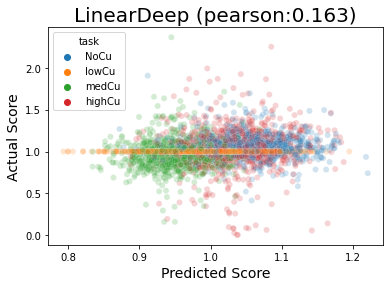

In [76]:
models = [
    ("LinearDeep",multi_lin_model),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = test_df['locus_tag'].values
task = "cu_test_LR"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

In [77]:
loc = 'EQU24_RS19315'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)

print(dna)
print(s)
multi_lin_model(s.float())

GCAGCACCAAATTGGACTGGTAGAGCTTAAATAAAAGCGTTAAAGGGATGTTTTAAAACAACCGCCCTTCGGGGTTTTTAAAAATTTTTTAGGAGGTAGA
tensor([[[0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 1., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [0., 1., 0., 0.],
         [0., 0., 0., 1.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 0., 1.],
         [1., 0., 0., 0.],
        

[tensor([[1.0922]], grad_fn=<AddmmBackward>),
 tensor([[1.0368]], grad_fn=<AddmmBackward>),
 tensor([[0.9490]], grad_fn=<AddmmBackward>),
 tensor([[1.0624]], grad_fn=<AddmmBackward>)]

In [78]:
print(np.mean(train_df['NoCu'].values))
print(np.mean(train_df['lowCu'].values))
print(np.mean(train_df['medCu'].values))
print(np.mean(train_df['highCu'].values))

1.0624554378229787
1.0
0.9525120016275621
1.034377542265467


In [79]:
multi_lin_model.lin_share.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0432, -0.0212, -0.0378,  ..., -0.0013,  0.0338,  0.0192],
                      [ 0.0151,  0.0141, -0.0400,  ..., -0.0307, -0.0136,  0.0459],
                      [-0.0233,  0.0397, -0.0314,  ..., -0.0147,  0.0229, -0.0328],
                      ...,
                      [ 0.0245,  0.0552,  0.0258,  ...,  0.0457,  0.0457, -0.0365],
                      [-0.0267,  0.0268,  0.0070,  ..., -0.0046, -0.0377,  0.0355],
                      [-0.0037,  0.0252,  0.0120,  ...,  0.0259,  0.0240,  0.0492]])),
             ('0.bias',
              tensor([-0.0318,  0.0179,  0.0242,  0.0191,  0.0398, -0.0011,  0.0133,  0.0226,
                      -0.0176,  0.1305])),
             ('2.weight',
              tensor([[-0.2326,  0.2767,  0.0746,  0.2628, -0.2232, -0.0666, -0.1545,  0.1107,
                       -0.1750,  0.1737],
                      [ 0.1710,  0.3227, -0.2757, -0.0524,  0.2093,  0.0168, -0.0096, -0.0603,
                     

### WEIRDNESS: all input sequences are seeming to predict the same output value for each task.
Maybe this is a bug? But also maybe this just means the model is bad an only predicting the bias? The values are pretty close the mean

Seq len: 100
Epoch: 0
0 0.9562765426341607
Epoch: 1
1 0.9549963057111873
Epoch: 2
2 0.953718078659664
Epoch: 3
3 0.9524415957687306
Epoch: 4
4 0.9511682848630568
Epoch: 5
5 0.9498961992818125
Epoch: 6
6 0.9486259517579175
Epoch: 7
7 0.9473577527813216
Epoch: 8
8 0.9460923871111615
Epoch: 9
9 0.9448301290843552
Epoch: 10
10 0.9435702167089016
Epoch: 11
11 0.9423112949866841
Epoch: 12
12 0.9410552530243445
Epoch: 13
13 0.9398027895325585
Epoch: 14
14 0.9385524426773633
Epoch: 15
15 0.9373043795355981
Epoch: 16
16 0.9360575349305448
Epoch: 17
17 0.9348130879453068
Epoch: 18
18 0.9335712379690874
Epoch: 19
19 0.9323310567815108


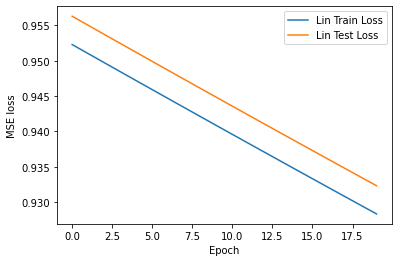

In [80]:
# slower learning rate
h1 = 10
h2 = 10
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_lin_model = DNA_Linear_Multi(seq_len, h1,h2)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_lin_model.parameters(), lr=0.00001) 

epochs = 20
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

lin_train_losses, lin_val_losses = fit_multi(
    epochs, 
    multi_lin_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

lin_data_label = list(zip([lin_train_losses,
                           lin_val_losses], 
                          ['Lin Train Loss',
                           'Lin Test Loss']))
u.quick_loss_plot(lin_data_label)

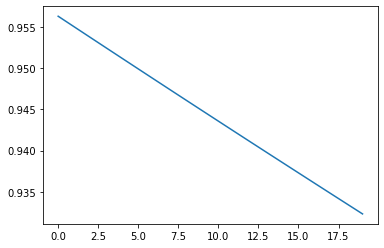

In [81]:
plt.plot(lin_val_losses)

Running LinearDeep


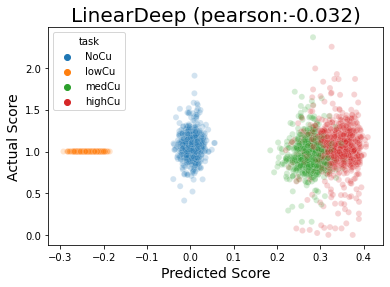

In [82]:
models = [
    ("LinearDeep",multi_lin_model),
    #("CNN_8mer",mer8motif_model_cnn),
]

genes = test_df['locus_tag'].values
task = "cu_test_LR"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

In [83]:
loc = 'EQU24_RS12525'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
print(dna)
multi_lin_model(s.float())

TATGCGAACGATGCAGAAACGGAAAGAGGCAAGTTCGAAGCGCGATAATAAATTAACATTTGCTAATGATGAATTTAATTGTTAATATCGCGCAACACTA


[tensor([[-0.0048]], grad_fn=<AddmmBackward>),
 tensor([[-0.2277]], grad_fn=<AddmmBackward>),
 tensor([[0.2267]], grad_fn=<AddmmBackward>),
 tensor([[0.2581]], grad_fn=<AddmmBackward>)]

In [84]:
loc = 'EQU24_RS00005'
dna = loc2seq[loc]
s = torch.tensor(u.one_hot_encode(dna)).unsqueeze(0)
print(dna)
multi_lin_model(s.float())

CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT


[tensor([[0.0141]], grad_fn=<AddmmBackward>),
 tensor([[-0.2411]], grad_fn=<AddmmBackward>),
 tensor([[0.2844]], grad_fn=<AddmmBackward>),
 tensor([[0.3632]], grad_fn=<AddmmBackward>)]

## OK, instead of trying to debug a knowingly bad model, let's start to try to create better ones??

In [85]:
class DNA_CNN_Multi(nn.Module):
    def __init__(self,
                 seq_len,
                 num_filters=32,
                 kernel_size=8,
                 lin_share_size=10,
                 lin_share_size2 = 10
                ):
        super().__init__()
        self.seq_len = seq_len
        
        self.conv_share = nn.Sequential(
            #nn.Conv1d(4, num_filters, kernel_size=kernel_size),
            nn.Conv2d(1, num_filters, kernel_size=(4,kernel_size)),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(num_filters*(seq_len-kernel_size+1), lin_share_size),
            nn.ReLU(inplace=True),
            nn.Linear(lin_share_size, lin_share_size2),
            nn.ReLU(inplace=True),
        ) 
        
        # define the multi task objectives?
        self.nocu_obj    = nn.Linear(lin_share_size2,1)
        self.lowcu_obj   = nn.Linear(lin_share_size2,1)
        self.medcu_obj   = nn.Linear(lin_share_size2,1)
        self.highcu_obj  = nn.Linear(lin_share_size2,1)
        
        
    def forward(self, xb):
        # permute to puts channel in correct order
        # unsqueeze adds dimension for conv2d
        xb = xb.permute(0,2,1).unsqueeze(1)
        # ^^ Conv2D input fix?? I think the unsqueeze adds a necessary dimension for Conv2D?
        #print(xb.shape)
        
        out = self.conv_share(xb)
        
        nocu_out   = self.nocu_obj(out)
        lowcu_out  = self.lowcu_obj(out)
        medcu_out  = self.medcu_obj(out)
        highcu_out = self.highcu_obj(out)
        
        return (nocu_out, lowcu_out, medcu_out, highcu_out)


Seq len: 100
Epoch: 0
0 0.030643404900037804
Epoch: 1
1 0.030807977107001085
Epoch: 2
2 0.03058601027378903
Epoch: 3
3 0.030461238306082015
Epoch: 4
4 0.030317079070358938
Epoch: 5
5 0.030246987478191104
Epoch: 6
6 0.030227833625242943
Epoch: 7
7 0.030262432497520607
Epoch: 8
8 0.03009089147881964
Epoch: 9
9 0.03006398730634017
Epoch: 10
10 0.030068389711236473
Epoch: 11
11 0.030013977662656868
Epoch: 12
12 0.0299670068438862
Epoch: 13
13 0.029909638155468276
Epoch: 14
14 0.029876700846626383
Epoch: 15
15 0.02994468409351536
Epoch: 16
16 0.029850999396051306
Epoch: 17
17 0.029830119601303925
Epoch: 18
18 0.02976349864292046
Epoch: 19
19 0.029760292416365547


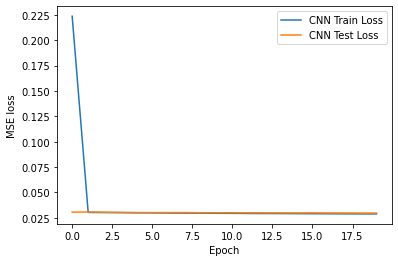

In [92]:
# faster learning rate
seq_len = len(train_df['upstream_region'].values[0])
print("Seq len:", seq_len)
multi_cnn_model = DNA_CNN_Multi(seq_len,lin_share_size=100)

loss_func = torch.nn.MSELoss() 
optimizer = torch.optim.SGD(multi_cnn_model.parameters(), lr=0.01) 

epochs = 20
# lin_train_losses, lin_val_losses = u.run_model(
#     train_dl, 
#     test_dl,
#     multi_lin_model
# )

cnn_train_losses, cnn_val_losses = fit_multi(
    epochs, 
    multi_cnn_model, 
    loss_func, 
    optimizer, 
    train_dl, 
    test_dl
)

cnn_data_label = list(zip([cnn_train_losses,
                           cnn_val_losses], 
                          ['CNN Train Loss',
                           'CNN Test Loss']))
u.quick_loss_plot(cnn_data_label)

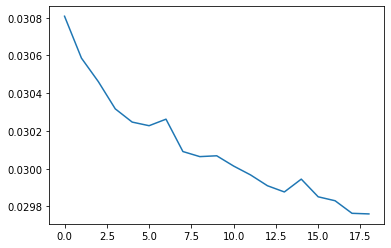

In [93]:
plt.plot(cnn_val_losses[1:])

Running CNN


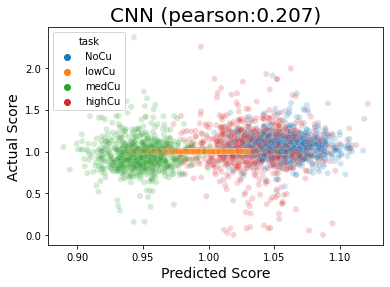

In [94]:
models = [
    #("LinearDeep",multi_lin_model),
    ("CNN",multi_cnn_model),
]

genes = test_df['locus_tag'].values
task = "cu_test_LR"

dfs = parity_pred_multi(models, genes, oracle_multi,task,alt=True)

In [95]:
df_cnn = dfs['CNN'][1]

<AxesSubplot:xlabel='pred', ylabel='truth'>

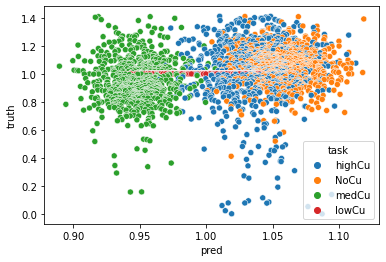

In [96]:
sns.scatterplot(data = df_cnn.sort_values('truth', ascending=False)[['truth','pred','task']].tail(3300),x='pred',y='truth',hue='task')

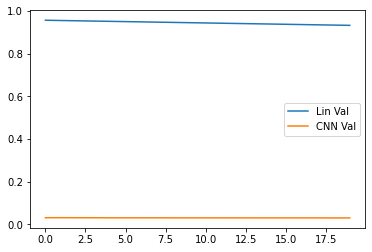

In [97]:
plt.plot(lin_val_losses,label="Lin Val")
plt.plot(cnn_val_losses,label="CNN Val")
plt.legend()

# inspect

In [98]:
multi_cnn_model

DNA_CNN_Multi(
  (conv_share): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 8), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Flatten(start_dim=1, end_dim=-1)
    (3): Linear(in_features=2976, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=100, out_features=10, bias=True)
    (6): ReLU(inplace=True)
  )
  (nocu_obj): Linear(in_features=10, out_features=1, bias=True)
  (lowcu_obj): Linear(in_features=10, out_features=1, bias=True)
  (medcu_obj): Linear(in_features=10, out_features=1, bias=True)
  (highcu_obj): Linear(in_features=10, out_features=1, bias=True)
)

In [99]:
def get_conv_layers_from_model(model):
    '''
    Given a trained model, extract its convolutional layers
    '''
    model_children = list(model.children())
    
    # counter to keep count of the conv layers
    model_weights = [] # we will save the conv layer weights in this list
    conv_layers = [] # we will save the actual conv layers in this list
    bias_weights = []
    counter = 0 

    # append all the conv layers and their respective weights to the list
    for i in range(len(model_children)):
        # get model type of Conv1d
        if type(model_children[i]) == nn.Conv2d:
            counter += 1
            model_weights.append(model_children[i].weight)
            conv_layers.append(model_children[i])
            bias_weights.append(model_children[i].bias)

        # also check sequential objects' children for conv1d
        elif type(model_children[i]) == nn.Sequential:
            for child in model_children[i]:
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
                    bias_weights.append(child.bias)

    print(f"Total convolutional layers: {counter}")
    return conv_layers, model_weights, bias_weights

def view_filters(model_weights, num_cols=8):
    # squeeze for conv2d??
    model_weights = model_weights[0].squeeze(1)
    num_filt = model_weights.shape[0]
    filt_width = model_weights[0].shape[1]
    num_rows = int(np.ceil(num_filt/num_cols))
    
    # visualize the first conv layer filters
    plt.figure(figsize=(20, 17))

    for i, filter in enumerate(model_weights):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(filter.detach(), cmap='gray')
        ax.set_yticks(np.arange(4))
        ax.set_yticklabels(['A', 'C', 'G','T'])
        ax.set_xticks(np.arange(filt_width))
        ax.set_title(f"Filter {i}")

    plt.tight_layout()
    plt.show()
    
def get_conv_output_for_seq(seq, conv_layer):
    '''
    Given an input sequeunce, get the output tensor containing the filter activations
    '''
    print(f"Running seq {seq}")
    # format seq for input to conv layer (OHE, reshape)
    seq = torch.tensor(u.one_hot_encode(seq)).view(-1,len(seq),4).permute(0,2,1).unsqueeze(0)
    # OHE FIX??
    # run through conv layer
    with torch.no_grad(): # don't want as part of gradient graph?
        res = conv_layer(seq.float())
        return res[0]
    

def get_filter_activations(seqs, conv_layer):
    '''
    Given a set of input sequences and a trained convolutional layer, 
    determine the subsequences for which each filter in the conv layer 
    activate most strongly. 
    
    1.) Run inputs through conv layer. 
    2.) Loop through filter activations of the resulting tensor, saving the
            position where filter activations were >0. 
    3.) Compile a count matrix for each filter by accumulating subsequences which
            activate the filter
    '''
    # initialize dict of pwms for each filter in the conv layer
    num_filters = conv_layer.out_channels
    filt_width = conv_layer.kernel_size[1]
    filter_pwms = dict((i,torch.zeros(4,filt_width)) for i in range(num_filters))
    
    print("Num filters", num_filters)
    print("filt_width", filt_width)
    #print("filter_pwms", filter_pwms)
    
    # loop through a set of sequences and collect subseqs where each filter activated
    for seq in seqs:
        res = get_conv_output_for_seq(seq, conv_layer)
        # for each filter and it's activation vector
        for filt_id,act_vec in enumerate(res):
            act_idxs = torch.where(act_vec>0)[1]
            activated_positions = [x.item() for x in act_idxs]
            # get subsequences that caused filter to activate
            for pos in activated_positions:
                subseq = seq[pos:pos+filt_width]
                #print("subseq",pos, subseq)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).view(-1,filt_width,4).permute(0,2,1).squeeze(0)
                #subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).permute(0,2,1).squeeze(0)
                # OHE FIX??
                subseq_tensor = torch.tensor(u.one_hot_encode(subseq)).T
                # add this subseq to the pwm count for this filter
                filter_pwms[filt_id] += subseq_tensor            
            
    return filter_pwms

import logomaker
def view_filters_and_logos(model_weights,filter_activations, num_cols=8):
    #print(model_weights[0].shape)
    model_weights = model_weights[0].squeeze(1)
    print(model_weights.shape)
    seq_len = model_weights.shape[-1]
    
    assert(model_weights.shape[0] == len(filter_activations))
    # make sure the model weights agree with the number of filters
    num_filts = len(filter_activations)
    num_rows = int(np.ceil(num_filts/num_cols))*2+1 # not sure why +1 is needed... complained otherwise
    
    plt.figure(figsize=(20, 17))

    j=0 # use to make sure a filter and it's logo end up vertically paired
    for i, filter in enumerate(model_weights):
        if (i)%num_cols == 0:
            j += num_cols
    #     print('i:', i)
    #     print('j:', j)
    #     print('i%8 == 0', i%8 == 0)
    # #     print('i+1%9 =?', (i+1)%9)
    #     print("i+j+1=", i+j+1)
    #     print("i+j+1+4=", i+j+1+8)
    #     print("*******")

        # display raw filter
        ax1 = plt.subplot(num_rows, num_cols, i+j+1)
        ax1.imshow(filter.detach(), cmap='gray')
        ax1.set_yticks(np.arange(4))
        ax1.set_yticklabels(['A', 'C', 'G','T'])
        ax1.set_xticks(np.arange(seq_len))
        ax1.set_title(f"Filter {i}")

        # display sequence logo
        ax2 = plt.subplot(num_rows, num_cols, i+j+1+num_cols)
        filt_df = pd.DataFrame(filter_activations[i].T.numpy(),columns=['A','C','G','T'])
        filt_df_info = logomaker.transform_matrix(filt_df,from_type='counts',to_type='information')
        logo = logomaker.Logo(filt_df_info,ax=ax2)
        ax2.set_ylim(0,2)
        ax2.set_title(f"Filter {i}")

    plt.tight_layout()

Total convolutional layers: 1


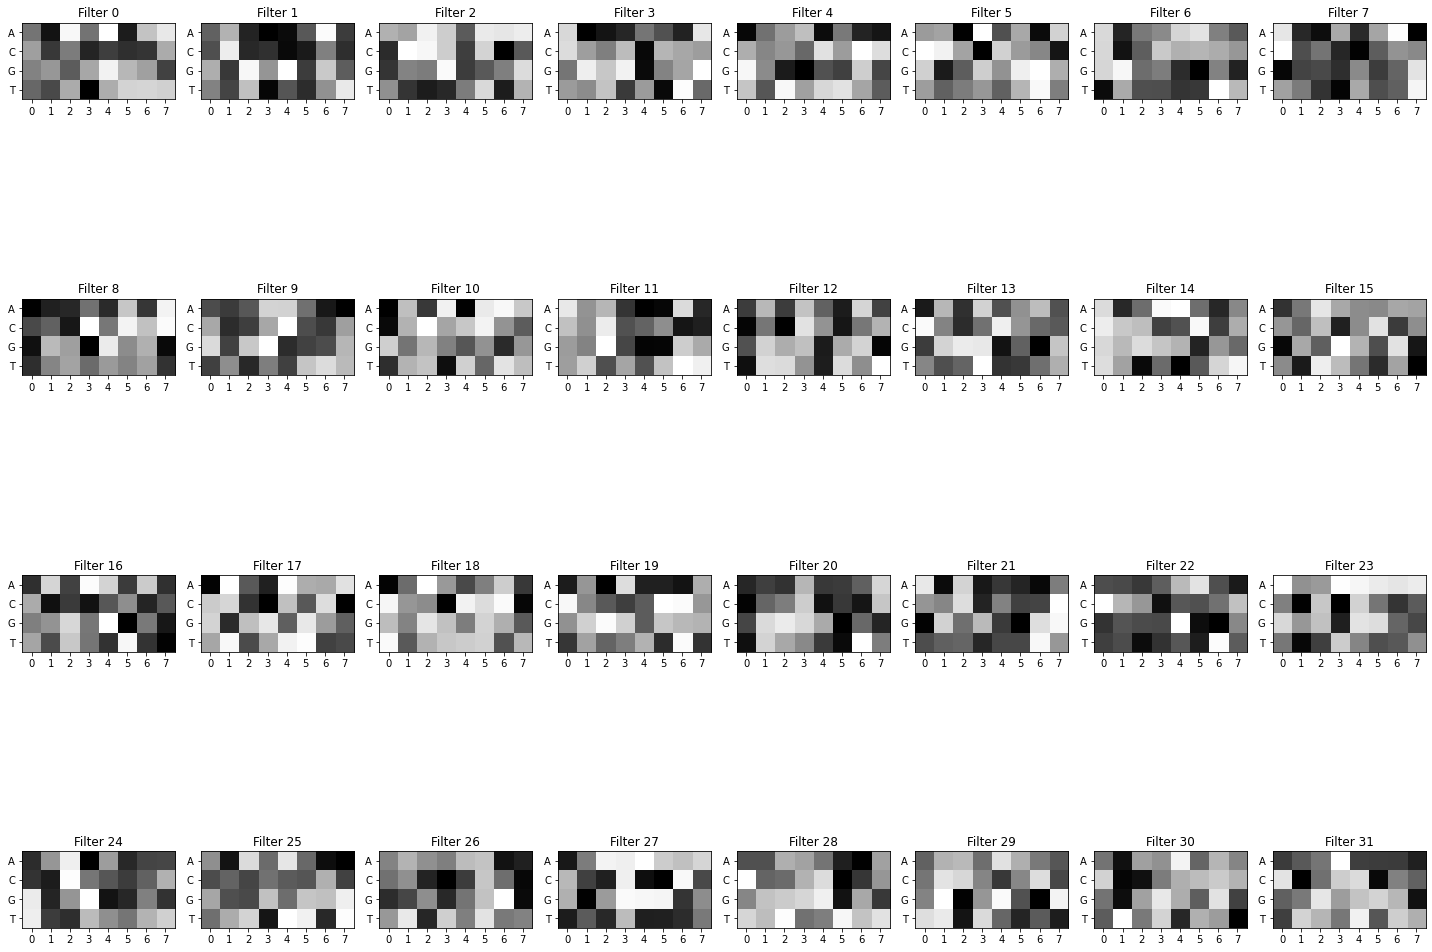

In [100]:
conv_layers, model_weights, bias_weights = get_conv_layers_from_model(multi_cnn_model)
view_filters(model_weights)

In [101]:
all_seqs = XYdf['upstream_region'].values
filter_activations = get_filter_activations(all_seqs, conv_layers[0])

Num filters 32
filt_width 8
Running seq CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT
Running seq AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAAATGACTTATCACGCTTTTTTTATAGGCTAATAGTAAATATAAATAAATATCTTA
Running seq ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGTTGTTCATCTAACCGGTGTTAACCGCGTGCTTTTTTTGACTAGCAACTAATAAAC
Running seq AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAAACAAGCGTAATGTTTCACGTGAAACATTGGTACATTGAGAAGGTAGTGAACACA
Running seq CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGAGGTGCGTGGGTATAGCTCAGCATAATCAAACATACAGAGCTGAAAAAGAAGAGC
Running seq TAATCCTGTTGCCGGATGGGGAAACCGTACATAACGCATTTATCGATAGAGGGTATAAACCATGAAAGTCAGCCTATTTCGAAGATACCGACACCCTATA
Running seq CAGCATAGTCACGGTAGGACGCGGTTAGGAACGAACCGCATTGATTGATACACGCCTGTTTTTTATTGCCACCAATCACTATTTGGCATAGCATAAGCCC
Running seq CACCCGTGCAACTGTAAACAGTTTATAGACCGTCGGATTCGCTGAATATCCGACTCGTTGTTTCAGTTGCGGCCCTGCTGCCGCATATTGCGGAGCTCAA
Running seq ATCCGTGCCAGAACCCAACAAGCCATCCTCAACGCCAAAGAACGTTCGGTGATCTT

Running seq GAATTTAGGTGCTGGGCGAATACGTCCATGTAGGCTTGACGGCGGCGACTGATTGCCATGGATGGCGTGTATTAGGGCACCAACAGTAGGCGCTTTAGGC
Running seq TATCAATCAAAATAAGTCGAATGCAGATTGTTGTTGCCGGTTTTTGGCAAACAGCTATTCATTAAGAGCTTGCCTCAATGATAGGCAGTCATAGGTTGAT
Running seq TCTGAAGCTTGGCGCCGGCACGACTAATGATTGAATCATGATGTTTGCGTATGACGCTTTGCTAATCCGGCCTACCGTTTTATTAAATAGTGCTTAACAA
Running seq TTTCGATCGGAAATACTTGATGTTAGCAGCTTCGATTCGGATCAGGTATAACCGGCACGTTGAGCAATTCGGTGAGTTTCATTTTGGAAGGGTTAAAGAG
Running seq GGTAGTTGTGTATTGTGGTCGCGGAGCGATTCTAAAACGGAATTATCGTGAGCAACGGGTTAAGCTGTTGACTCGAGCATTTGAAACTCAAAGAGAGATA
Running seq GGGAATGGTGATGTTACCCAGGTATATCGTCGGTAAGGATATCGAAAAAGGTAAGTTAATGCCGGTATTGGAAGATTATGGATTGGCGCCCCTGGAGATA
Running seq AAATTCTAACGGGCCTAAGATCGAAAAATTGAATCCGTTGCGATCTGTTTGAACAACACCCCTTTAACGTCATTTGCTAAACTTAGCCGATCGATTCCAT
Running seq CTAACCATTCACAACTTGCCTTTCTCAATATTCGGCGACTGACTTCTCAATTCACGAGTACAGGTTGCCGCATAATTCATTAATCATCAGAGTTTATTTA
Running seq GCTTACAAAATAAGATTAGTCTTTAATTAGCAGCGAATCGCTGCATAATTGATTTTTTTCATAGTAGAATAAGCCCGCTAATTA

Running seq CTCTTTTTTGCGCCTTGCATAGGGGAAAATACGCCATCCTGGCATATTTATAATAATAATCGTCTTATTCTTCTTTTGATCAGCTGTTGCTGTAGCCGCC
Running seq GAAGCTTTCGAACAAGGCGGCTTCAGAGAGTTGGTCGCCAAAGCCGTACTCGCCGCACATAGCCGCTCGATCGAAATGTCCAAACAATTGGGAGAACAAT
Running seq CAAAAACCGTCAATGAACAAACTACACAGACCTTGCGATTTCTGACACAATCCCCATATCGGGTTAAAATACCGTAACCTTTGAAACCATATCTCAACAT
Running seq GTTTACCCTGTGCTCCACACCCTTTTTTAACCTCTAATTGTGAATTGCTGTCGTGTATCAAAGCGCTGACATGATTTTATGGTTTGCGTTAAACTCTGGT
Running seq CAGCAGGGCATGGTGTCTTATCGCCAGGATTTAGAACAGGAGATGATGGACTTTTGTAGCGAGCAGTTATCGGCCTACATACCCGAGGATAAATTTTTTC
Running seq TTACCATGAAGAGCACTCCAGTCCCGCTATTGTTTTGATATTTTTTAATCATTAACTGGATTAGAAAACCAGCAATTCCCAATTTGGAGATCAAAAAGGG
Running seq GCGCGAGATTAAAAGCCATTCCCACTCCACGATCGTCAGTTCCACCGGTATAATCCGATTTCCTCAATAAAATTTAGTAACAATGAACAAGGCATCAAGA
Running seq GATAATTTCAGTGAGCCGTGAGCGGTAAACGAATGGGCTTGGATTATAGTGATTTTGCGGGCCGACAAGCCTGTGGTGTTGATTTAGATGGGGATAGTGT
Running seq TAATCTCTTGAAATACTTAATGAACTTCATGGTTAAACTGCTAAATTTAGGTTAATAAACTCTTAAATCACATGGCAATAAAAA

Running seq CGCCGCATATGGCGATGTGTATTGGGTAGATGAAGATAGCGATCTTATTGTTATCGATCGCATGATATGATTTCATATCATACCGTATCATATCATTCGC
Running seq TTTAACTAACATATATATATTTTAGTATTGACGGAAGTTTTAGGCTAATGGAAAATCGGTTATCTATAAATATAATTGGTATTGATCAATTTACCGCCGC
Running seq TGATCAATACCAATTATATTTATAGATAACCGATTTTCCATTAGCCTAAAACTTCCGTCAATACTAAAATATATATATGTTAGTTAAAGTTGGTAATAAC
Running seq ATCCGGTGGGATGCGATGGTGGAGTTGAGTTTTTCCGGTAGTGGAAAAAGTGAGTATGTTCCTAGTCTATTAAATGGCCTGTAAGCCTCTAGGTGATAAA
Running seq TGCTGTGGTTGCGAATATGGCCTCGATGATAACGAACCCTACTATGAAAAATGGGTATCGGAAGGATGTCGTTGGCTTTATCCTAAAGCAAAACCAACAG
Running seq TGGAAACAACCGCCCATAGCGGCTAGAGTATAGCAAATAAGGGTATACGGCTTATTAGCCATGCAAATAAAATAGGCACTTCGTTTTTATACACCGAATA
Running seq GTGTTAGGTTCGGAAAACCCGGCTTATAAAAATATCGTGCTTCGTGAAGAGATTGATACGGTGATTTGGGGCGTGGTCACCAATGTCATTCACCCGCTGT
Running seq TAAGAGAACATAATAAACGCCTTTCGGCTTCTTCTCACTCTCAACCCGCTATGCTCATTATGCCAACGACTGTTTTATACGCTGCTTCAAACCCTAAAAC
Running seq TAATTGGCTTATTAACGTTGATTTTTTTTAAAAAAAGGTTATTGTATTCATTGAATTTTATGAATTCAAATAAACATACTTTGT

Running seq CAAGTTCTATTAGATTGATACATTAATAGAAATGGAGCACACAAGTCCTCCCGCAGCGCAGCCTTTTCGTTTTTAATTTTAACTTCAGAACATATTTGTA
Running seq TCTTTATACATAAGTATAAATATATCTAATTGTGCAAAAAGTAGCGACCGAGCGCTAAATTACAGCAATTCCCAATTTGGAGATCAAAAAGGGTGTGGGG
Running seq ATTTTCCGGCAAGCCTGAATATATGGCCGTTCATTATTATCATACAAGGCTTGCTGATGGTTTCGACACTAAAAATATCGCGAATCTTTTGAGGCTCGCC
Running seq AACTGGGATCGGCCGGCGATGACTAAATGGTTATCGCTTCATCATCCTGTCACAATATCTTTTTACGATCGCGTATCGGGGTTAATTTCAGCGGGGCGGT
Running seq TACGCGATCGTAAAAAGATATTGTGACAGGATGATGAAGCGATAACCATTTAGTCATCGCCGGCCGATCCCAGTTAAATCGAGAACAGTCATCGATTTGT
Running seq GAGAACAGTCATCGATTTGTCATATTATCGAGCCAATATAAGATTTCGGAATCGCAACACCGCAGCAATTCCCAATTTGGAGATCAAAAAGGGTGTGGGG
Running seq AACCAGTTGCAGTAAAAGAAAGCGTCCGTCTGGCTGCAATCGAGCGGTTGAGTTTGACTGCAGTCAGCCCGATCAAATCAACCATAACAATTGAGGACAA
Running seq AAGAGGCCTTGATTTCAAGGGCCGATACGCCGGCAACCTGAACCAGGAGGCCCGCACCGATTAGTGATCGAATCATTTTTTTCATTTTGTCCTCAATTGT
Running seq TAATGACGGTATCGGGGGGGGCATTTTAAGGCGGGTAAAAAAAACATGAAAAACAGTATAAACGGTATATACTGTTAATGAACT

Running seq GCTACAGCCTAACCCAGCTTGCAGGGCTTTTAGACTGATTTGCAGAATCATTTTCACAACTTATGGAGCTTGAGGGGAGAAGAAGCCCCTAAATTCTCAC
Running seq GGCTACATGATACGTGCTTTAACGGCAATCAAAACCGCACCGCAATTGAGTAGCCGATTATCATGAAACGACTTATTGATGACCCAGCGCCCGGCGAACG
Running seq TCAATGGCAGTATGGATCCGGGCGCAGTTAGTGGCGTGAAGTGCGTTTAAAACAAATACCGCTTATAATCTGACCAGACTGGTTAGAATTAGAGGTTGAT
Running seq AATCGGCAGTCGCTGGTTGAATTCATGCGTCGTTCGCCACTTTATGATCAGGACGATCTCATCATAGAACGCGATGCCAGTCTGACCCGTGAATTCGAAC
Running seq TATTCGATCGTAAAGCCTTATGTCGATCAGCTTGGGGCATGATTAGCAATGAGTGTTGGAATTAAACAACCCGGGTTCGACGCCCGAGTAAGGAATTCGC
Running seq GGGCTTACCTTAACTTAATGGCAGTGACGCAGAGCGTGGGAACGAAAATTGCCGGGGGACTGAATAGTTACAATAAAATAAAATTTCAGAGGATAAACGT
Running seq AGCGAATACCGCACTCCGATCGGACAATCCTTGCGTGTCGCGAAAAAACAGGCGGCACCCGAATTGCTCAAATTGCCGGTATCGGCACCGGAGACGGCAC
Running seq GATCTATTTGTTGGACGAGGAAAGCGCGGCGTTGGTGGCGAGCCGTGGAGGACAAGTTCGTGTTGTCACCGGCTGAAACGATCGACATCGCCCGTGCCTT
Running seq GGAGCGCAGCGCAATCCGGGAAGGCCGAAGCCGCGAAGTCCCGTATTCCGCTACGCTGCATACGGGCTACGCAAACAAAATAAC

Running seq CTGCTTCCGGAGCAGTATCATAAATACCCGGTTTAACATTGAAACCGATTGTCCCCATTGATCTTTTTTCCTAGACACAACTCTTTTTTCGGAAATTTTC
Running seq ATGATTTTTCTAGGAATAAGGAACGTGCAAAACACTATTTTACTACTCAAAATTGGGGCGAAATAATTGGGGAGCGCGTTTTGAAAGAAAACATTCAGCA
Running seq CTCAAGGTAAAATCGATTCGCGTACGGTTTTGGGGGTTAGTTTTGTGCCCTTTACCGGTAAGCATATGGAATCGGCCCATCATCAATGGAGTCCGTAAAC
Running seq GATGCGCTGGCGGCAGTAAATATCCATCCTCAGGATGGGCTTGAAGCCGAACGAATAATGGCGGACGAAGGCGCCCATCTTATTACATTGGACGACTTGT
Running seq TATTGACGCGCGAAGAAAATTATCCGGTCGTTATTTCAGATGCTCTCAAGCATCTTGCGCAACGTGTCGACGAAGGTTATTCATAAAGGTTATTTTTAAC
Running seq GACCCCGGCTCTTGAAATACGCTTCTTAACGCCTCAGCTTATTCAAGATACTCCTCAATGATGCGATAGCGTTATCGCATTCTTTCCACTCGGGGATTAC
Running seq AGTATCTATCTATCTATCTATCTATATCTATCGATGCGGTCATTTCAAATGAGTTACTGTGCATTTGCGGGTCTATTTTCGCTAAACCCTAGTCGATATC
Running seq ATAAAAGATAGAACGAAAATTCAGAGTAAGTGTCTCTTTGGCTTCAGGCCCTTTTTTGCCTGTGCCCAGTCGATATTTATCTAACCGTTCAGGAGGTTGC
Running seq ATTGGCGTTAACTGTTAAAAAGGACATCAAAAGACTCTTCACTGCTTAAGAGCCTCTGAAAAACAAGGTCGCTGAAAAAACGAG

Running seq GTCTTTTGTGACCGAATGTGACTCATTCTACTTCAATTTATCCAATGAGCTGAAAGAAAGATGTTATTGAGGCGTAAATCGATCGATTCTTTTGTTTTCT
Running seq CTCATCCGGTTTGGTTTTGTCAAAGTTAACGAGTACTGGCATGCTGCAGTCGTTTGACATGACGGAAAGATCCTCATTTTTGCAGAGGCTTGAAGGGCTT
Running seq GCCCGTCGATCCGGTTCGGTGGTGCCGTAAAATAGATCAGGATCGCACAGGATAAATGTTTTATTTAAATCGGAAATCAGAAGTTTGGAGTTTTTAGGGC
Running seq AAGAGAAAAGCAAATTGGAAATTACCGATTATCCGCTTCATGAAGCTTTGATGCTGCTGAAAGGGATCGCAATTTTGCGGAATTAACGTTTCGATCGGCG
Running seq CTATTGCCCGTTGGTAAAAAAACGCCCAGTTTCATTTGCCGCATGAATGCCCAAGCCTCATCGTTATCAATCTCCTAACCCATTAATTAGACTGTAAACC
Running seq CTGTCTCTATTGATAATAACCGGTGTAGTTGATTCGCGGAGCATCGGTTTACAGTCTAATTAATGGGTTAGGAGATTGATAACGATGAGGCTTGGGCATT
Running seq AAGATATAACTTTCGAAAACGGTTGTTAATAACAAAGGTATAGAATGAATTTTCTTTTCAAGAAATCCGCTTGGACCGTGTGGTCGTTTTGTCTGCCGTT
Running seq GTACTTCCATGCGGAAATGCCTAAATTTGAAGCGCGAAGTGTATATATGATGAAATTGGCACAATGATTTAATTTTCAGATCAATCGGGTGAGGTAAGTT
Running seq CTGAGGGGCTGAGGATTCCTGCGCTTTATCCTTAAATCTTGACTAAAACACTAGGGATTGTCATACTTTGATAACTTTTTAATT

Running seq TGCGCGAGCCTGAGAGGATTTATTTTGCGGCGCAACCCTTTGCACTCGGTATCATCGAGGCAATAGAACATTATGATTTTTAAGTGACTGAGAGCAGAAT
Running seq GGCCGAAGGCGATTATCTCGGCATGAACGGTAATTACAGTGCCGGTATTTTAGAAGGCGTTGTGCATTATTTACCCGAAATCAAATACTGGATCATTAGC
Running seq AGCAGCCGAACCCTACAGGAAATAGGGACGTTATTTATGACCAAATCCTTAGCTTCTCCGCTGCCGGGTTATGACCCATCACATTTACTTCAATTAGAAT
Running seq ACCCCACACCCTAAGATCGGCGAAAAGGCTCAAACTGGGAATTGCTGACCGAACCCCCTTCCAACAGTTGTCTAACTTATTTCATGCTCGTTCCTAACTC
Running seq TCAATTAACGGTGCTTTCGGTCGCTCACGATAAGGAGTGGTTGGTGCGCTGCGATCGTATTTTAGAACTGGAAGCGGGCCGGTTGGTTGGGGAAAGGACA
Running seq AAGTTATTTTGTGCATATTCCTAGCGATCTATCAGCATCATTCAAAAAAGCCAGTTGTTTATTAATCGAACGCTCCTACACGACAAAAAGAAGGTAACCC
Running seq CATTCTAACGCGAAACCATGGCTTTAACATTTTTGCTAAGGAACGAGCATGAAATAACTTCGACAACTGTTGGAAGGGGGATTCGGCGGCTCGATTGACA
Running seq AGTTATTTCATGCTCGTTCCTTAGCAAAAATGTTAAAGCCATGGTTTCGCGTTAGAATGACGAACCATAAACGTTTATTTTAATGTAGGCAAGTATATTC
Running seq ACCGGCGAAGGATTAAAAAACTACGCCAATCGTTTATTCCGCAGGCCGGCTTTCGCCGCTAGCTTGAGTAGTGCCGAAAAAGAA

Running seq GCTGGCAGGACTATTGGTCTTGCCGGCTTATCCTCCTATAGCCCGAAAATAAGCGGAAACAAACAAGTTCGGCAATGGCTCAGTCTGAAATGTCATAATC
Running seq GTTGGAGGCCAATCGAACTATCGCGCCCTTCCGCTCGGAAGTCTCATTGTTCTCCTTCTGGTAAAATGCGCGCTTCGATTCAGTCGGCGACGAGGATAAC
Running seq ACGACATCGATCTGCAATCGGTTGCGTGACTGCCGTTTGCTATACCCATCGTAGCAACAATTCCCAGTTTGAGCAGTTTCGCCGATTTTAGGGTGTGGGG
Running seq AGTCACGTTGGAAAAGTGCTTAATTAAACTGCAGTCCGTTGGTAACATACGCAAAATTCCGATACGATACCTCTAAACTCTATGTTTTAACAGTATTTTT
Running seq ATAATGCGCAAAATGCCGCGAACCGTAATCGGCCCAGGGCAAACGCATTAAAAATACTGTTAAAACATAGAGTTTAGAGGTATCGTATCGGAATTTTGCG
Running seq GATGAATCAAGCAAATTATATTCCTTACGACTCGAAAGTCTTCTTATCACCAACCGGATTCTGCTAATCTGTTCTTCTATTTCAAGTTTCGGTGTAAAAC
Running seq GAGCTACTCAGGCGTTCCAACGCAGAGCGTGAGAACGTTAATTGCCGGGGGGCTAAATAGTTACGATCCAAAAGATTGTGTTCGTTACACGGAAAAAATT
Running seq GCGTTTTATCAGCTGCCTCCGCATCAAGTCGCTAACGGCATGCTCGATGCGTTGATTTATCTACTTGAAAATAATAATCAAACAAAACAAGGAGATTCAC
Running seq AACTTAAAGGCCGTGACGCTCTGCGGGGGAATGATAGAAAATCGGAAAGTTATTTGCACCCACATCCTAAGATCCTGTCTAATT

Running seq AAGCGTCAAATAAATTTTTTAAAATCCTGGATATGACTGTGTCCGGGATTTTTGTTTATTAGGGGAGCTGAAAAGCGTTTGCACCCGTTTTGGAGTAAAT
Running seq AAGACAAAAATGGAAGATTTAAATGCGGCAAGCTTGGATGCCGCAGTTAAAACAATTGCCGGAAGTGCTCGTAGTATGGGCCTGAATGTGGAGGGCGTGT
Running seq GCTGGAACCGCAAAGCTGGTGAAAGGGACCGTAAGGGGCATCTACTGAAGATGCGTTTTATTGATTCTGATTAAAAATCAGAAATGTACCGGAGGTAAAT
Running seq GTTGGTAAGCTTGCACGGACATTGGCTGCACTTAAAGACCTTAAAGAAGCGGCATAACCTTTTTTTAACCAGTTTTAAATCTATTTTAGAGGAAATACAT
Running seq TAAGCCTCTTAGTATGGCTGGTGACATTTTGTCATCGGCCTTTTGCCGCTTATTAATAGGCGGCAAAAAATAATTCCTGATGAAATAGGTATGGAAGCAA
Running seq AGTTAGAAAGCGATTGAGTTCGATTATTTACCTTAATTTGACTACCCGTTCCGGACACGCGCCGGAAACCATTTAGAGAGGATAAGCTCTTGAAAGATTT
Running seq TATTTGTCAGGATAAGCATTATATGGCCGCTGTGCATAAAAATGTACGGCGGTTATTTTTATTGTCTGGCGGGTAAACTGAATTATCGGAGTAACTAATT
Running seq TCGCGGAAGTCTTGATACTTCGGGCGTCAAAAATAGAAAATGCGGTCGTTCGAAGTACGGAACGAAAAGACCTAAAGCCTAAGCGAAGTTTGGTGGATTA
Running seq GTGCAGCCGCCAAGAAACGAGAAGAAACTCATCGTATGGCGGAAGCTAATAAAGCGTTTTCTCATTATCGCTGGTAATTTAAGC

Running seq GCTTTTTTAAACGATGAAAAAGATAATAACAAACAGCCTAATGATCTTGCCGAATGGCGAATTAAACAGGCAACTCAATTAATTAACTGGAGGAAGGGAA
Running seq GCCGAGCTCAATCAAGCCAGGCTAAGCTATCATATTACCGACCAGAGCCAAAGTTGCTTCCGGCTCTGTTTACCGAACGCGGAACAAACTTTGATTGAAA
Running seq GCACCCTCCGCCACGCCTCGAACTGTCATTTGCCGGGGCGATGACCGGGCCTTCATGAATGTTACTGTAGGTTTATTTTAACCAAGCCGCAATAAAACAC
Running seq CGGGAGTTTGTTTACCGGTCTAATATAGAAAGCTATATTTTCGAATTGGACCTAAATGTAAGCAAGATATCAGGTAATTTTTTAACCACCGGAAAATAAC
Running seq GAGGCGGGGCGCAGATTACTTCGGGAATCGGGATTGAATTTAGTAGCGGCCGATGACTTGGCAAAGGCCGCCGAACAAGTAGTCGCACTGGCGGAGGGTG
Running seq AGCATCAGTCAACCCTAACAACCCAGGATATTGCTGTTGTACCCGCGAATCCTTCAACGGTTATTGACATAACACAAGCTCAGCAAACGCGACTTTTATG
Running seq TCGTTCACTTTACAGTGATTTTATTTCCTCAGCTTGTGGATTTAAAATTATCGCTGTATGCGGTACAAATAGGTCTTATTTTAACCCATCCCCCAAATAC
Running seq GCAAGACATTCTCGATGTTTACATCAAGCAAAGACAGGAAGACGAGTCTTTCTTGACTACCGTTAATCGCGTCGGCATTACGCCCTTTAAAGAGCAAGTT
Running seq TGACGCAGAGCGTGGGAACGATAATTACCGGGGAACTGAATAGTTACGCCGGCTCACTTATTCGCCCTCCTAGGGCGCTTTTCC

Running seq AGCATTTTCGACGTCGGATGCTTGGGCGATCGGTCTCGGTCGGTCATCGTAGCGCCCCTAATGAACGAGCATGAAATAACTTAGACAACTGTTGGAAGGG
Running seq GGCAATATTAAAGTGTGCGACGACCGCACAGGCAACATCGGCGTCAATATAGCGCTTAATAATGCGGGAAGACTATTAACGCAACAAGAGATCGCCTGCC
Running seq AGACAAAAAATAATAGTTAGCATTTTTTTAACAAGCTCTCATAAGCCTTATGCAATTTGTGCTACGGTCATATCCATACTAAGCAGGCAATTTTCATTTC
Running seq ATGCCGGCAGTTCCCGGAACAACTCCACCCGAAACGAATCAACTCGCTTTCTACACCGTTCAATTTTTTTCACCATTCATTCTTAAATGAGGCAATAAAC
Running seq ACAATGTCCGATTTATTTTGCGCCCGGTTCGGGGCAAATTTAACCGAATCGAGGGTGACTTTGCCCGGCAAAAAATTCACATATTGAAATAGGAAGACAC
Running seq GAAGCAATTGCCGCAAAAGGCCAATAATCGATTGGAGTAGGCCCGCGCCGATTTTCGGCGCGGGCCTTTCTTTACTTTTTTAAATAGAAAGAGGTTGTGC
Running seq GCGGCTTGCCGATCATTACCGCCGAAACCTTGGCGGAAGCGGCCGAGAAAGCCGTGCAAGCACGTAATGAAGTAGTGGCGAGAGAGGGCTGAGAGAAGCA
Running seq ATTGCTTTTCGGCAAGCTGCCGCTCATAACTCATAATGCCACAGCGGAGTCTTGATAGACTCCCTGTGGTTTTGTTTTTTACGAAGGATTAATCACGCGT
Running seq AGAATTTAATCGTTATGCGTATTTACCCTTTCGCCCTTGCTTTTATGATGTACATGACTACGGCTGTTGCCGAACAAGAAGCAT

Running seq ATCACATATCAACCGACTGAAAGCCATCGGCTTTAGTTAACGTGAAGAGGAAATAATCCATGAAATACACATTACCATTACGACTGTGTTCAACGATCGT
Running seq AAAACCACAGCGGTAAGATTGAGGTAGAATCCTACATCGGCAAAGGCAGTAAATTCAGAATATGTTTACCGCTGACTTCCAATGGGTGCTAATGCGGCAC
Running seq CCCCTATTTTTAATGCAAGGCAAGCAGGTTCGGTAACTCGCTACAAAACTCATAGCTCCAGGAAGTTATTTTTCACGAAATCCTTAACCGACTCGAATAA
Running seq TCGTTTGGCGTAGACTGGCGTAAGTGTATGGGCAGCAATTCGTTTTGCGAATGGCGGCTATACTGGATGTTTTATTCATCGGTCGATTTTTTCCTAAGGT
Running seq TAGTTCGGCGTTGACCGGCGAGGGCATCATCGAGACCTTCAAGGCTTTGTTGGCGGCTGTTTATCTAACCTGCGATCGGCTGTACCGCTTGCAATCGGAT
Running seq GGCGGCTCGATCGATATCGTGAGCCAGATAGGTAAGGGAACTCGGGTAACGGTTAACTTACCTGTGCATAACGCCATTCAGAACCCTAAAGAGTCTTAAC
Running seq AAAGGTTGCTAAAAGATTATGAATATCATCTTGAAATACCTCACGAACTTCATGTGCTTCATGGTTAAATTGCCGAATTTAGGTCTCTTAGGAGTTTATT
Running seq CCTACATGGACGTATTCACGGCGTCCTTTGACGAACCCCCCGGTGCCGAAATTTGACCAGCAAAGGGTATACAAGAAACTAAAGCAAGTTTTGGAGACGC
Running seq ACGTGTAATAACTTATTGAATTAACCTCCTATTCTTCATGGTGAAATGCTTTTTCTAGGATAATAACAACAAAACTCTAAGATT

Running seq TATATGATTTTAATTTTCAAAAATGAAATAGGCAGCTCTATGACGCAATATTTTGCGTCATTTAGGATGTCTAATTATAGTTAGGCAATTTGGTAAAATT
Running seq TGGTTTAAAGCCGGTTTCCGACAACAGACTTTGATGGACCTACCATCATCTTCCAATGAGCTTATACACATCTGATCGCTATTTCCGTATAGCGTCAGTT
Running seq CATGTCGAGCGCTTTTATGACGAGCCGCTCTTGCAACAAGAACGGTGGGCATCGCGCTTGGAATTGAACGATTGTTTATTTGAAAACGCCTGGAACAACC
Running seq GCGCCTCGTGCACCATTACAGCAATCGCCCAGCCGCCCTGAGCCAACCCAAAGACCCGTTCGTTTTTAAAGATCTGCTCGTACAACACCGACACGCCGCC
Running seq CACTAAAACCACGCTATCGAAAGCCTTGTCCATGAAAACACCCATTGATTTTACGATCCTCGGCCTATTGGCCGTTGGTTTCTTGCTGTCTTGATCAAGC
Running seq GATTCGCGTGTGCGACAATTTTGAAGGCCTGGATAAGCGGTATGTGCGCTTCGCGGTTAAGGATGCCGAATCGATCGCCCGGCTTGCCGAATGTTTGCAA
Running seq TCCGGTTACGGCTTGGCCCCTCTGCGCCGATATTCTCACCCCCGACGCCCCGTTTGGTTTAAAATAATCGGCTTTTGACTTCGCACGATACGCATTGCTG
Running seq TAAATAGGCTATACATATCATTTATATAATGATTTTAATGACCGCACACGCCTCACGCCAACCTCAAAAAATCTTACCTCCAGCCAACCGGCAAAGTTCA
Running seq TAAATTGGTCCGGTTCGACGCCTGCTCTCAACACTTTCACTCTTCACAAAGCAAAATCACTACTTATTTCCAATTTTAACTACA

Running seq CCAGCCATTCCCAATTTGGAGATCAAAAAGGGTGTGGGGTATGCTTGGCGAGGATGTCGGCAGCAGGGCAGATTTTTGCTCCTCGGCAACTGCTGAGTTA
Running seq TTACAAAAGTTACATATTTGCATTTCTATGATATGCTTGCCGTTTGAAAAGCCTAAAAAATCTAGGCGCAATAACGATTATTCTAAGGGGAGGAGGTTTT
Running seq GTAATATAAATATTGCAAAAGCATGGTATCGAGACTAAACTTGCCCTTGAGCCTTTGATGCTCAGCGATAAAAATATAAACATAAACAAAGGAAGATAAC
Running seq AAGAGTTGAACGTTCCTGACAACCTAATCGAACAAGTCGCTTCGATTGCAGAAAGTACCCGCAACGATGTTTTAGGCAGATAATTAAGGGAAGTTTTGAC
Running seq CCGAACCTCTTTCGGTTATTTTTTGGGGTTCCGTCAATCGGCGAGACCATCATTTTCATTCATGCCAGCCGGATTTCGCTGCGCAAATTCTTGAGTCGCT
Running seq GATCATCGGCTATTTTTTTGCACCGATAGGCATCTGGCATCTATGTGTTAAAACGCATCATGATGAAGAGGTCGCTATAACAATAAATAAGAGGAGGAGC
Running seq GCCGAAGCTAAAGGCGTCGTAGCCTTTTTGAAATGGATGTCGAGTATCGACACGAACGGCTTTCCCTATAACTTTAAAACCTTGTACGCGGAGGATTGAT
Running seq CCCGCTCCAAGTGTATCGAGGGTATCGGCTATTTTTTTCGCGGCGACAGCTTCCTTATCGGCTGGAAATCTGGGTTTGTCCCGATCCGGCGCATCGATCA
Running seq AAGCCTTTGTCGGACACCCCGGCGCCTCCTCGGGCACTGCCGAAATTTGAAGTGCGAAAGGTATATAAAAATGTTATGGCTTGC

Running seq TGCCGTTGCATTAAAGTTATTGATAACAGAACGCCCGCGCGTTATTGGGTATAAATTTAACAGGCCGGGATATCACGAATACTTAACAGAAGGGTAATAC
Running seq GGAAACCGGGGCAACCAACGTCTTCATCAACGACTAACGGCCAGGCCACTTGAACGGAAAAAGCAAAGCGCAAAATCATAGCTAACGGAAAACCACTTAA
Running seq CTTAACGGCAACCACCTCTCGAGCGTAGCGAGAAAGGCTCTTTAATTTATCGTTCAGGTTATTTGCGATAAATACGCGACATCCACTAGAAGGAAGACTT
Running seq GAGTTTGCGTGAATGACAGATTTTAAACTTTATCGATGTCGGGTACAATTGCCGGCCTTTGTTGATCCGGTATCGGAAATGGCGCTTAGAGGAAATCATA
Running seq GTCGGTAATAAATATCCGGAATACCGGGAAGTTTTACAGCTATTTAGACAGCAACAGACTGATACTGTATTGGCGAATGCCGATCCGAGGAGTGTTAAAT
Running seq GCAGACCGACGATTCTTGAAAGCAGGCTTCCGGTATCCGTTTCTGGACCCCGTCCTTATTTATAGGATAGACTGACCGGATTATTTTTTCAGATCTTGAT
Running seq CGCTAGAAAGCTCATGATTTCAGGAATTTATTTGTCACGAAACCCTAAGTCTCTTGGATTCAAAATTTTAGGACAAGCGATTGAAAGACCTCATGTGCTT
Running seq CATGGAGGGCATCACCTTAATCGCCGACAATCGCAACCCTTCTTTTGTAAGAGAAACGCTTAAATCATTTATTGCTCATTATGACAATGAACTGAAAATC
Running seq TCCGACCAGAAACGCTAAATAGCTTCGAATGTTTAATTCAACATTTCGCAAAGTCCCTTTTTTCTTTAAACCATTTGCATAGCA

Running seq AATCGAGCATCAACTGTATAGGCGCCTTTCGGGAACATAAACCCACACATGCCTGTTTAACCATTAATCTCAAAGCAAACGAGTGAATAGCGCCATCATC
Running seq TTTTTGTATGGGTGAGATCAATTTCAGCCACTTAGCTTTAATTTAATTTCCGGTCAAATTTGTATTGTCGGGCAATTAAACCTTTATTGAATAGTATTTA
Running seq GAATCCCCTTGATGCTAGTAGGATGTTAATAGTGCGTCGGTCCTAATGGTTTAAGTTTTTTAAACCGGTAAATTTATCAACCCATGAAATGCTGGAGTAC
Running seq AATAGGCACTAAGTTGGCGCTTATGGGGTGAATAATTACGCACAATTTACTAGAACACCTATACTTATCACCACTTTAAAAACAAATTTCGAGAGTGCAA
Running seq CGATTGAATTAAGTTAAGCCTATTGATAGGAAAAAATCAAAGAACCAAGCTAAACATATTGGGTCTATATTTGTAACCTTGTGCTTAAAAAATGTTACGC
Running seq TGATTTTTTCCTATCAATAGGCTTAACTTAATTCAATCGCCTTTTGACCGGTTTGATCGGCTGCCGGCTGTTCTTTGGTATTAACCCTTCTCATATTTCT
Running seq TCTGGGCCGAGTCGGAAGGGGAAGGCAAAGGCAGCACGTTTGTTTTTGAAATTCCATTGGCGCAGAATAATGCATCCGATTAGTTTTTCAGCGAACGCGC
Running seq AATCGATCGGCTATTTCAGTTTTTCAGCCGACTTCAATTAAGATCCTGTTACGAAGGAACCGGCATGGGACTGGCATTGTGCCGTAGGATCGTCGAACAT
Running seq TATATCCAGGCTACCCTTTGCTCTTACGCGTTTCGAAAATTAGAAAAATATAAGGAAGCACTATGAAAATAATAAAAACTTTGC

Running seq TCAGGCTTCGACTTGGCTCAGCACGAACGGTCTACAACACTTGCCAACTGCTCTTTTTAGGATAAAAGAGGTTAAGCCCCTGAAAAGCTAGAGTTTATGA
Running seq GGCGACTTTGGTGAGCTTTTGCATCCCGCTTGAGAGAATGAGCAAGACGATGTCCCCAGCTGGCAAGGCTATTTATGAACTTTCATCAGGAGTTTATGCC
Running seq CTACCGAACAAAATAGCATTGCCATAAAAGCCGAAAATATGACCGTGCAAAGTATATGCTAAACTTCGCCATAACAACTCGCATAAAGCTCAAACCGTGC
Running seq AGCGAAAATCAAAGGAAGATGTCGAGTTCATCTAAAGCTTGAAAAAACCGAACAATATATATACTTCGCCATAACAACTCGCATAAAGCTCAAACCGTGC
Running seq GAGTACCGCTCCAGCGGTACGAGACGCTAGAGCGTCTCGGGCTGCATTCCCACGCTGGAGCGTGGGAACGATAGGGGGTGAATAATTACCTGAGGTTAGT
Running seq GTTTTCGGAGCCCCTTGCGCTATGCTAGACTATCGAAACGACCGGGTTTAACGAATAAATCCGGTTAAAAGTGCATCCGCCGGAATACCAGGAGCGAGAC
Running seq AAATCAGAGGACGATGTCGAGTTCATCTAAAGCTTGAAAAAACCGAGCAATAGATATGCTAAACTCCGCCATAATATCCCGTATTAAGCTCAAACCGTGC
Running seq TATTATCGACACCCTAAACTTGCCATGATCGGTAAAATAAGCGGTTTAATAGTGCCCGGCTGGCTAATTTGCCAATACACCCCAAAAAAATCCGTTAACT
Running seq TTTAGTTGGCGCTTATGGTTGCAAGCCACGTTTTGCCAAGAACCCATTCCCATAGAGTGAAAGAACACCAAACCCTTTTCCAGT

Running seq TGGGAAACAGCGGAAACAGTGACCAGGACACTCGGTTGTCTTTTTGCCTTCGATCATGCCTAGCCGCGATACAGGAATTTTAGAGAGGAAAATTATTTTT
Running seq AATCGCCGCCCGGTATTAGGATAACCCCTCGAGCCTTCGGCCGCGATCGGCGTTATCCGATTACGTCCGGTTACAAAGGTATTTGAGATAGTAAAGAAAT
Running seq TACACTTTCATTAGGGCTTTTTTTGTTTTCGATTTGGTGATTAAATAGCCGCCACTTTTCTCCGTTGTAATGACGGGGTGTTTTTTTTAGATGTACATAC
Running seq ATTCGTCGACGTGTACATAGCCGAGGCTTTGCCTAACTCTCTTCGCGGGCGTATGGTCGAATCTTCGACCGCAAAAATAACTGCGGTGGCTTAAGCAATT
Running seq AGTTTTACGTTTTTCGGCGCGAAAGACGTCGTCAGACACCCGTTGGTACAGCGAATTGTCCTTGCCTATGAGGCCTATGAGAAAAAACATTCGAACCCTT
Running seq GATCATGTCGAAGATAACGAAGCCGAATTAATGGAAGCGAAAGAAATCGAAATATTGGCACAATTGAACATCGATAATCCGTATAACGAGGCAAACGAGG
Running seq TTCGTACTTAAAATTTCGGCATGTGCGTATAGGGACAGCGGACTGTTCGTCTCTAACGGGATAACTGCCGCCAAACCCCTATTCACAACTAGAGGTGCAT
Running seq TAGGCGCTGCCGAAATTTGAAGTACAAAAGGTATATATGCAAAATAGCGGTTACCGGTAGGCAAAGCCTTCAATAAATCCTAGCAAACTTGAGAGAAAAG
Running seq ATTAAATGCCTTTTTCACAACTCACTCTCTAATGGAATTTCAACAGCTATTATACATAGAGTATAATCATGCCTACTTTTACAT

Running seq CATGGCCGCAGGCTTTGCCGATTATCTGACGAAACCCTTGGATGTGCTAGAATTTCTCAAATGCATAGACCGTTTTAAACACAACGCCGACGGAAAACCT
Running seq GCCGGCTTCGCGGACTATTTAACCAAGCCGTTGGACATCACGCAATTCAACGCCGTTTTGGAAGATTTGCTTAACCGCATTCAAAAAGATCCGGATTCAT
Running seq CCTTTCCATGGCACCTAACCCGACAACAGATTCCGACCCAAGTGCGCGATGCGCACCCTGATGCTTTATAGCCTTTTCAAAAGTATCTCTAAAACCAAGC
Running seq TCGCGCCGCGCAAATCATTCACAATAACGTACAACGTTGCCGCAGTGCTTTGAATGTCATTAATATTAACGAATAACCGTAAAAAATAAGGCGAAAAAAC
Running seq TTGATTATTCAATATATTGCCGGTAAAACATAGAATGCGCGACCGTTGAAAAACAAAACCGATTTTTTTTATTTCCAACACCATCACTCAGTTCAAGCGC
Running seq AGTTTTCGGATTAACTGCTTATTCTTCATGATCTTCATGGTGAAATGCTTTGTCTAGGTTTGTAGCCGTTGCAACGCCTCAATAAATTGGACGATTCTTA
Running seq GCGGATACGGAAACCGGTACAGGATTATTGCGCGGCATTTAAGAATCGTCCAATTTATTGAGGCGTTGCAACGGCTACAAACCTAGACAAAGCATTTCAC
Running seq AAGGCCGTTATGCAAGGTTCAATGAATGAAGGCGATATCGAATTATTTTAACCGAAAGCACTCATTCAAGTTTTAACGATGCTCATATAGGAAGCAAGCA
Running seq TATGCCCGGCGAAGCTTATAAAATCGGAGCCGCCGATATCGTTCTGCCGATCGATCAAGTCGCGGAACAAATTGTGGCTTTAAT

Running seq TATGTAGCATTCATCAAATAAATAACAAAAGATACTTGCCAACATCGCTTGACGATTTGTGATATCCACACTGACATTGTTATTTAAGAGGAGAAAACGT
Running seq GACCAAAATTCCTACAGTCTCCCGGTGGGGGGCGGTATCGGGTCGGAAAAATCTGCACGACCTGTTAAGAACAAACTTCGCATCATCATTCAATATAGCT
Running seq TTATTTGCCTTTTACATCTATGATTGGTGGCAGATTCGAGCTAATGGTTTAAAATCCTGGCCGACGGTATTATTCGCTAACTCCCAAAGACAGTATCAAA
Running seq ACTCGATGAGATAAAAACATGATTCATGGCATTCTTTTGCCGTCCCCGCTAAATTCTCAGCAGATATAGCTAATGGTGCTGTATATCGCATAGGTTCGTT
Running seq TACTGTATTATGAATTAAATGGCTTTAGTTAGGGCGCGGTAAGCACCAATTTTTGAGACGAAGTGAGTTACATGATAGATAGCTATTTAAAAAATGAAAC
Running seq GGCTGCGGCTACGACTGGACCCCGCTCGGATTATTGGCTTCGGCAAACTGAAGCATCTTGCTAATCAGGTGTCCTTATGTGCTTCATTTGAATTGCCGCC
Running seq ACTTGCTAATCAGGTAAATATTTCCCGTAAAATCATGCTTGATAACGGTTATCGAAAGACTTATTATGGCTATAAATATAGCTATATTAGAGGTGTCTCC
Running seq AAGGCCATCCAACAATGGCGTTGTCAATTGGACGCGGATAGCGCCTTGACTGATGCCGAACTCAAACAAATACGTGAAGCCAGCCAGGAACGGGAATTTT
Running seq ATATTGACTGTCAGCTTAGCTGATTGACTGACAAAACTCAAAAGTCGAAAAGATTAGGAGATAATATCGATATTTGACCGGTTC

Running seq GCCGAGATAAGCGTATTGGCATAGAATTCATGGGGTATTGCCGAATGTTTTGAAATGTCTTCGGTATCATACTTATAAAAATAAACAACCTAGAGGGTGC
Running seq TACTCACTACTCACTACTCACTATTCACTATTCACTACTTACTGCTTACCGCTTACTGCTTACTGCTTACTGCTAACCGCTAACCGCTAAAAGAGGTCAT
Running seq TGTTTGAACTTTAGCTGAACGGGACAATTCCAACCAATGCCGTTTATAATTCATTCGACTTCTCGGATTTATCGCCGCTGACCGCTATTTTTTAAAAACC
Running seq CAGTGACGCTGGAGCGTGGGAACGATAGGTGGGATGTAAATAATTACAAAAGTAGTGAGTTCGATGATATCCATCAGCTCTCGGCATTTTACTCGAAGAT
Running seq GATATGATCGATGCATTTCAACACTGTTACACAACATTTAAACAGATCGCCAAACGATTCGACGATGATACCGCAGCGTCGTTATCGGCAATCTCAGCGA
Running seq CGTTTTGGGAAAAACACAAGGCAACGAATTGCTGCATCTGATTTCAATATTCGAATGGGAAAAAGCGCTCGATATACTCGAGCGGCACGATGATTAGGGC
Running seq TCTCCAAGCTAACGTTTGAAAAATACTACCAAGGCTTATAATCCTTGGTAGAATGGTGCCGGTTTAATTGCTCTTAACATTAAAATAGGTTTCTTCGCAT
Running seq CCTTGTCATTCGCCCACAGAACGTCGCTGGTTTTTGATGCACGCCACGCCTGTGAGGCATCCGTTGGGTGGCATCATTGTCAGTCATGTCAATATCACGG
Running seq TTATTGAACAAAAAACTGAATCACTTACAACCATATTTTCGAAACTATTTTTAGCGATTATCTAAGCGTTTACGGCCGCACCGG

Running seq ATTTTGAATACTTTCACAGTATCAGGACCGTGGGAACCAAAAATCCGCCCCAAGAAAATACCCGCTTCTTGAATGACTGCGATTAAAACGGTAAATCACT
Running seq GAATCACGTCAGGATCGCCTTAGTAGCACCGATCTACGAATGTATCGATGCTGCAAGGCGCATTAAAAATTTCATTCACACGTTATAACAAATGGAAAAT
Running seq CATGCCACTCGAATTCAAGAACTGCAAAATGCCATACCAAGAGCATTAGAAATTCAAAAACAAGCAGCCGCTCAAGGCAAACAACCTCGTTGCAGTAAAT
Running seq ACCGAAATTTGACTTGTCTGATTAGAGTATGTTCTCGCCGATAATCGCATAAGTATTCCTGATCAACCTAACGTCTTCAATTCGGCAAAGGGTACCGCAT
Running seq TCGGGTTAAAATGCCTGCCATTGCTGCAGTGTCGGTTCGCGTTATTCGTTTAATCGGCATGGCTAAATCCAAATCAATTTAAGATAAAAGAGGAAAAGCG
Running seq TGCGCCTCAGCGCCTTGGCGCGATAATGATACAATTCAACCTAATAATCCGATGTCTATGTGCTTCGATGTACTGCTCATCTCTAATCATTTGGAAAAGC
Running seq GCTGGCAAAGCCTTTGTCGAACACCCCGACGCCTCCTCGGACATTGCCGAAATTTGAAGTGCGAAAGGTATATTTCCTATTTTTTTGGCATTTACATCCG
Running seq ACTGGTTAGAGAATGGGCGAAAGAGCATCAGGAAGAATTAATGGCGGATTGGCAGTTAGCCATTCAGTTAAAGCCGTTGCAGCGTATAGCCGGAGCCGAT
Running seq AAAATTGGAACATATCAGCGTTTCCGCGGCATTATCAAACGAAAATAGATTGATAACAGCCGTAGAAGAAATAAACAAAAAATC

Running seq GTAAAAAGCCGATTGGGCGTTAAAATGGCCGGCCGGTCCGAAATCGTTTGTGAAAAGCTGCTCACCGGCATTTGCCGTTCTTCTCTATTCGAGGCCTCTG
Running seq TGAATAATTGTTGAACCGAGCCTTGTTAATTAGTATCAATGAAAAGAAGGGAGTTTTTATATCGATTGGGATGTTATCCAGCTAATTTTGCGGAGAAGAT
Running seq TCCTCTTTTGGAAAACCCGACGGTCGCTAAGAAACGCCTTCCACGGCACGACCGTTGGCAAGGTATTGGTTAGTGTATGAGGGGTAAATCAGGTTGTCTT
Running seq TCGTTCTACAACTTATTGGATAATGGCGGCTTTTGTGCAAGCGAACTCTATTTCTCCTTGCGATTCTCCTCTCGTCAATTAGGATATATTCTGTGAAGAA
Running seq AGTCTGCGCGAATAGCGCAGGCGGAGGCAAAATACAAGGCATCGCGACACGGCGTAAAGCCATTTGCGGGAGTGCTACGGAGCCGCATCGAGTATACGAG
Running seq CATCGCCAGTCGGCTCGGAAATTGGGAAAAAATGCCGTTGTATTTCGGCATGCGGCCCTGGACCGACGATTTCACGAATATCATCAGCATTTGGAAGTAA
Running seq CGGCAAACCAACTTCATTGCTAAGACCAACACCCCAATTCCATTGAAAATGCTTTATCATAGCGCACTCGAAACAGCATACTCTTACAGCCGATAATAAT
Running seq CAATCCAGCCATAAAGTCATAAATGGGCAGTTATTCAAGGCAAAAACAACTATAATCTAGAAAATTCCACTCAAATAGCGATTCCGTATTAACAATCATT
Running seq GGCTAAATGTATGACAGTTGCGGTCTACAATAGGGGGGTAGACAATTTAGGCTTTGATTGCTACGCTTTAGTTTCAATATCAAG

Running seq CCGAAATTTGAAGTGCGAAAGGTATACTTTAAAAGAAGGGCGGAAAAAAAATAAAAAAAAACTTGAATAATAAATTCGATCCGTTATCATATGCGGCTCA
Running seq GTGATGAAGGGTGAAGGATGAATTCACAATTCAAGAACCCTGTCTTCATTATCTTCAAATCCCAGCAATCCCCAATTTGGAGATAAAAAAGGGTGGGGGG
Running seq ACCGAGCTTGTCATAGTGGAATCAAATACCCAGGTTTGTTTTACCCATCTGGAAAGGTTATGGCAGAATAAGTCGGAGAACAATTTTGAGAGAACCACTT
Running seq CTTGCCATTCGATTTTTCCGCTTGCATCAAATGGTGTCAATAACGCTACAATAGGGCCATGAAGTTGAATCATAAAATCCAATGAGTTTCAGTAAAATCA
Running seq TCAGCAATGTTTGCGCGATATCGCCGAAATAGGTGGTGTTGGGGTATACATCACAACTGAATGTTACTAACATTTGATTTTACTGAAACTCATTGGATTT
Running seq CGAATCGAAACTGCGCGAAGCAACGGCCAAAATGCTGGAAGCACCGACGCAGCCTCAAGCCGAATCGATTCCGATGCTTCACGATGCGGGGGATCACAAG
Running seq AATTACGGTCTACGACTTTGAAGCGCAATATTGGCAAGCCTTCGCCGAAGCCAACCAAGCTTTGGCGCAGCTTGTCGCAGCGACAGGCAAGGAAGACATT
Running seq TGTATGTTAGCTCCTTAAACAAACTTAACTGGATATTTACCATGCTCCTCAGCTCTCATCATGAACCACCGGCCGTTTTATAAAGGACATAAGAACCTCT
Running seq TAGCTTGAAGGCTTTAGGCTTTAGTGTAGCGAACCTTTCGAATTTATTTTTAATTATCGGTATATAATGCAAAGCCTTATAAAA

Running seq TTTAACGATAGTGTCGATATGAACTATAGTAGTTCCAAAATGCCTCCATCCCTTAGATTGACACATAATATAGAAATCTAACGCTAATACGAGAAACATC
Running seq GGCACCCCGGCGCCGAATTTTGATCTGCGATGAGTATAACTCCGGTGCCGCAAAGACTGGATTGATAATGTATAATTCCCGCAAAAAATCGGAGTTAATT
Running seq TCGAGCAAGCAGGATTTACCGCGCGCCGTAAAACGCTTGAAATTCACGGTATCTGCAAGCATTGCGCCGATGGCGCGGCATAGCCGCCCGGGATCGCTGC
Running seq CGAAACGCCCGAGGAAATTGCCTTATCGATCATGGCCGGTATTCATGCCGCAATGAAGGGTCGAACCGGCGGACAATTAGGCATTTAAAGTTGCATTCAC
Running seq ATAAACTTCAGAAAATTCTTTTACCCGAAGCGGAACTCGATATCGATACCAGGGAAGATTTCGACCACCTAAGCGGCCATTACGATGCCGGGGAGTGAAC
Running seq GATGAAATCCGGACAAAAATGACCAACTATTGCCGCTGCGGAACCTATTTGCAAATATTCGAAGCGGTCAAACAAGCGGCGCAACTTCAAGGAGAGCAGT
Running seq GCCTGCCGAATTTGGTGGTCGTCGGGAATCAGGACTCGATCAGCCGAACACGAAGAAACGACTTGCACTTAATTTGCTGAACCCGCCTTGTATTGAAATC
Running seq GCCCTAACGTCCAGCGCGACGGCCAACTATTACACGCCGATCCGGCGCAAGTCCGCTTTCGCCCGGTTCTTAAAGCCGGCGCACCAGCCTAAGGTCTTCC
Running seq GTACCCTCAAACCTTCGAAGTGTTATTATCGGCTTGTGCCATTCATAGCGCTCATATAACATAGCTATGCACTAATTAGAAGTA

Running seq CAAAAGTTAGCGCAATTAAAACAGATGCATGATTCCGGCTTGATTACCGAGCAAGAATACGCCGATAAAAGAAAAGAAATTCTCGATCGTTTTTAAGTCC
Running seq AAACGCAACCGTTATTGAAGTATTTTATATTTTTTAACCGTTACTTAAGCTTTGCTGAATCTAATACCGTAAAATCAATTCAGCTTGAATGAGAAATCTA
Running seq TAAAAATTTGGAATACTGATTCGACTGTTAGTCTAAACTGCAATCGAGTATAGCAGAAACCGCACCCGCTTAATGACACTTACTAATGATTAAGAACAAA
Running seq AAGCGGGTGCGGTTTCTGCTATACTCGATTGCAGTTTAGACTAACAGTCGAATCAGTATTCCAAATTTTTACTTTTGGCGAATGTTTTTTACGGAATCAG
Running seq CTGGATTTTATCCAACTCTCGCCGGAAAACTCGTTACATATTCTTCATGACGCGCAAACTAAAATTAACGAAGCCAAGCGAGCTTTTGCAATATAGATAC
Running seq AGCTGGATTCTCAATTATTGACACCTGAACAGTCACTGCAAATATTGCAAGATGCCAAACAACAAATTAACGAAACAATGAAATACTTTCTGGCTTGACG
Running seq CGGTAAATTGACGCCGGACTTTTCACTGCATATCCTGCACAAAGCGCGGCAGCGCATCGATGCGGCGATGCAAATTCTTTCTTGATCGATACCCAAAACA
Running seq CTCGAACAAGGCGGAAGCGACGACGCGATGGAATTGTTCATCCAATTTCGCGGACGGGAACCCGAAATCGACGCGCTGCTCAGACACAACGGAATCGCTG
Running seq GGATTTGTTTTAATTGCCTTCCTGTGGGACGGGTTATTTAACCCGTCCCCAACGTTTCGGATTGGCCTAAGCGGTTTCGGCTTG

Running seq AACAATCCAATGCACCCGCGCGGCAAAGTCTGGCGTTTTCAAATGGATCACTCGTCGCCGCAGGGTGATTGGTAATGTTAGGCAAATAGGCAATAGAAAC
Running seq CGATAACGCCCTGGTTGCCTTTACTTTGTTGATTGCCGAAAGCAAACCGGAAGAAAAAGATACCATCGTCAAAGTCATAATCAATTTAATCAATGGTAAA
Running seq TGCAAAATTGGCGCTTAACGCTACCTTATGGACACGCGATAAACGCCTATTGGCCGTTGCTACGCAGCTCACTATGAACTATCAACCCTAAGCATCAGCG
Running seq AAGGCCCTGATTGAACGCGAGAGCGCCAAGCGCCTAGCCAGCCTGGGCGGTATTGCCCCCGATTTGCAGCCCATCCCGCGCCGGCAAACCGAGTTGTAAC
Running seq CGATACCCTGCTTCCCAAACTCATGAGCGGCGAAGTGCGGGTGAAAGTTGCCTAACTGCACAAAAAAGCGCATCATTCGATGACATAGTACGGAGGACAT
Running seq GGTTTATTACCGTGGCTGCAAGCCCAAATACTGGCGAGATTCTTGCGCGGCGATTGCGACAGCTACGTGCCGTTCTTGTGGAAATAATGGGAGATAGATC
Running seq AAAAAATGCCGAAACTGTTCGTTGCTCGAACAATGCCATCCGCAAATATTTGGCAAATCCGCGTCGGCCTGGTTGGCCCGGCAACTTGCACAGGACTGAA
Running seq AGCTGGAAACGCTTCCTGGATTGCAGCCGGAGGAAAAAGAAGGCTTTTGACGACAAGCTGTAGGAGCGACTTCCAGAGCGCGACTGAATGGTTTTCTGCA
Running seq TCCGGCGAATTTTTGCTGGCATATCACTGCCAGCGGCAAAAATTCAAAACGAAAACAGACACTCACGAACCCAACGAAACTGAA

Running seq TAATAATTGAAAGAGGAAAATTCTATTTTTGACATTGGCTGGATCTTTTCTCACGGCCTGTTGAATGTCGGCCAATGCTTGTTCAAGATTACCGTCTTTC
Running seq AGCGATAGATAAACTCTCTTGGAAATTGGTTAAATCCTTTTTGAGATTATTCATCAGCAGTTTGTAATTCTATTTATTTCTGTAAATTATGAGGATAAAC
Running seq CGAAAGTAATCAATGATCCGGCTTTATTGCAGTCGCTGACCGCAGCGCCGAAGCCGGCCGATACAGCCGAAGCAAAAACCGAGGAAGGGGGAGAGTAAAC
Running seq GACGGCGTTAGCCAAGCCAGTATCATCATGGGGGCTAAGAGTGAAGATGAATAAATTAGGCTCGGAATTTCTGTTACAAATTTCTATCGAGGAGGTGTTA
Running seq AAGCGGGAATGTTTAGGTAATCTCTTGAAATACTTCATGAGCTCCATGGTTAAACTGCCGAATTTAGGTTGAATACAATTGTCGTTTAAGGAGTGAGTGC
Running seq ATCGACAACCTGGAAGCACGCTATGAATTGAGCGCGACCAGCGTTGATAATCCGTTCGCCCTGAAAGAATTGCAAAATTTTCAATTTCCAACGAGCTTGT
Running seq TTGATACAGAATTTAACTATTCTGGCGGACCTAAATTGGAAGCCAAATATCAGAGCCTAGTGGACGGCTCGCCTTATAAGACTTGTCAATAAGGGACAAG
Running seq TTGCGTTGGATTGCCAACTCTCGGGCTTGTCCGGAATGGCAAGACTTTAACCCGGGTAAAACTTAGTTTATCGTATACATGGATCTTTTCAGGGGATAAT
Running seq TGGAAGCAAATGGCTCAGTCGGGCGGTTTTGCCATCCATATCGCCGGAGAGTTTCCAGGGCTTGAACTTGAATTTTGGGCAATC

Running seq CAAGCCTGATGAGTGTGCAACAGTTTTTCCGGAATCGAGGCTTGGAACAAGCAACTTTCGGCTATTCGAAATATGTTTTTCATTACCAACGAATTCAAAT
Running seq GATACGATTGGCGCTGCAATTGCACTATTCGTTCTGTATAAATTCACAACGCGCGCCCGCTTCCGCTAAAATATTCTGTTTTTTAAAAGCAGGTTAACAC
Running seq ACGCGGCTATTTCAAACACCCGGAACTGCAAACTACCTATACCTGGAAAGACCTGGACGATGAAACCGAAACCCCTAAGCTGATGACATTCTGGTTGAAA
Running seq CGAAAGTTGATGCAAAAATTACACCCGGATCGAGGAGGGTCGGGTTATTTGTCGTCTAAGATCAATCAAGCAAAAGATTTATTACTAAAGTATGTAGCCT
Running seq GACTAATTTTTGTAATCGTGAAGAATTAGGAACTAAGATATGATCCTAAGGTTGAATATGCAATTATTTCAGTAAGCGGATCATTTTAATCGGAGAACAT
Running seq TTCTCCGATTAAAATGATCCGCTTACTGAAATAATTGCATATTCAACCTTAGGATCATATCTTAGTTCCTAATTCTTCACGATTACAAAAATTAGTCGAC
Running seq GGATAGTCCGCTCGAATTACCCAAACATTTACCGGGTTTCGACTTAAATAATCCGGATATGATAGCCGATTACATTTTAAACCAATTCTTGGAGCGCAAG
Running seq TTACAGTTCTCGCAAATACCGAATTTGTTGATATGTATAAAAGGCTTACAATGGCGATCGTTTTTTGAATAAAGTTGAAAAATAGAAGATCAAATATGCC
Running seq TGTGATTATGTGTAAACCGACGACTTAAGCATTTGCCATGTTAACTTGAGTTTTTTTGGATCTTAATAAAATGAAACTTTACAT

Running seq GAAATCAACAGTATTGCGGCGGGCAATCTGTCAAATCGTTTTTTTTAGGTTTGTCTTCCCCGCTATTCATTCGCCAACCAGACTTGGGAAGGACAACAAC
Running seq ACCGTGATTCTAGGCCTCGGCTTCATGCAGGACGCCAACAACTACATTCATAATGCCGCACACGACGGACGCCATAGCGCCGCATTTCCCTGTCATTAAG
Running seq GCCCTATTCTGGCTGAGCCTCGGCGCTTTAGCCGGATTCAGCATGACCAAACTCAAACTCTGATTATGAACACTAGCCCATCCGTCCGCCATTGTCCGGC
Running seq CGCAGCCAAGGCGAAAGGTTTTTCCGCGTGGGATCGTTGCAAGCCTCTTATCTGCACACTTATTTTCCGTTCAACCCGCAACAAGCTGCAGGATTTTTTC
Running seq GCGCGCGCCATTGGCCGGACTTAAAAAAATCCAAACTTTACGACGCCGGCTTCACGCATCGTTTTCGCCGCGCCGAGCAATCAGATTCTTAAGGAACACG
Running seq ATGCCGCCGACCCGAATTCGCCGAAAATGCTCGAATGCGACGGCTGCCAATACCGCGAACAGGCCGCGCATCAGCACCATCATCACCATTGAAGCAAAGC
Running seq CACCCGAGGCCGCAAAGGCGGTTCGACGCTGGTCGTAGCGGCGCTGCATGCGCTCTTGAGTTTGGCGGAAAGCCGGCAACAAAACGGCTGATTCGATGGC
Running seq GCCACATTGGAACGGCGCTACCCTGGGAGCTTCGACATCGGCGTCTTGGTTTGCGACTTCGACGGCAATAAACTGGCGCAAGCCGGAAGGACTTAATCTC
Running seq GGACGCCTGCCAAATTCAGGCATCGCGCAGCAGTCCGATACTCGATATGCACCGATTACAAGCGGAAAACCCGGTATGGATCAT

Running seq GCCGATAACGCGCTGCCGGCTTACGAACATTGGCGGCAACGGATACGGCGACACTTTATTTAAGCCTGTATCGCAGCCTCACCTTAGAGGATACCAGCAA
Running seq CTGCGTTGGCGCGGACAAGCCGGCAGCATGCACCGTAAGACGCTCAACCTCGAACAGGGCTGGCACACTGTAATACTCGGCGAAGCAGAGGCGGAAAATT
Running seq GCATTATTTGCCGTTTGCGCTTGCCGGGGAGCCGGGCTGTATCTGATCGCACACCGCCAACGACTGTTCCAGAATGCGCAACTTGCCGAGAGTGCCGGAA
Running seq CTACATCGCAAAGCTCAAAGGCACTTCTTCGCCATTGATGTTTTCGATATTGATCGAACAAAATCGCCAATCAAAATCGCCGGCAGCATTCGGGAAGTAA
Running seq AGATTCTACTCTTTAGCGATCCGCTTTTAGCTTCTGTACTCTTTCGCTGATCAATAAAGGTATAATGACCGGCCGAATATCGAATTTTTCTGAATAATCC
Running seq CTGACCCGAATGTGCCGGGCCTGTCCCTTTCCAATACCATGGCGCAACAAGAAGCCCAACAATTACTGGCCGAATCCGACAGCTACTTCCAAGAGTGACT
Running seq TAAATCGAAAATGGAACGGGAAGGCATTCTCAGCCAATCGATTATCGAGACCCTAAGACGGCATTTAAACGACTTTCGCCAAGGCTCAGTCCACTAGCTC
Running seq GTCTGGATTTGCCAACTAATTATCCCATTCGGCTTCGGCATCATGAGCCTGCGCTTTGTATTGCATGGGCTTTCGGTCTTGCTGAATAGAGAGGCGCCCT
Running seq ATGATCTTGAATTGACAATCAATTTAATATTTTCATCATTATCAACAATCGCTAAACTATGCTGTTATTCAAGAGCGCCCCTGC

Running seq GCAAAAATCTGCCGCCGAAACCTGCCAATCGAGCAACCGAACCCTCCGAAAATAGGGAAGTTATTTACGACCAAATCCTTACCTTCTTAGAGAGTCGATT
Running seq CTTGACGGCGGCGACTGATTGCCAAGGATGGCATGAATGCAGATTTTGCATTACGCCATGGATGGCGTGTATTAGGGTACCAACAGTAGGCGCTTTAGGC
Running seq GTGAAAGTATTCCTCATTCCCACCGCTTCAGCGTGGGAATGAATAAGATGAAATATGAATGTGGTAGATTTTTGGGTTTTGTTACGGGGATTGGGTGAGC
Running seq CCCCTTTTTTGTAATTTACTTTTCATATTAACTTGTTAGTATTCCAAAAATATGACAGTTTATGGTAAAGCTGCTTTTGACACATTAATGATATCCCGCC
Running seq AGTTCGAAGAATTCGATCAACCCGATATTCAAGATGCGTTTCATTCGTTATTCGGTTGTTAGCGCCGGCCGGCCTCAAAACATAGGGCACAAGAAAACAC
Running seq TGACCAGTATTTAGCAACTTGGTTCGACGAAGAAACCTGTGAAACCTTGGCCAAGTCTAGCGGATTTATTCAACGCAGCACGAGTCGCTTGACCGGCAGC
Running seq TCCTCTTTTGGAAAACCCGACGGTCGCTAAGAAACGCCTTCCACGGCACGACCGTTGGCAAGGTATTGGTTAGTGTATGAGGGGTAAATCAGGTTGTCTT
Running seq AACGCTCAAACTGGGAATTGCTGCTACGCGAATCACATTGATGTTTTTTACCCGAATAGGCGTAAAATGACAGATCCAGTATTGACTTCTATTTTAGTGT
Running seq GCAGTGTGGGTTACGGCTACCCGGCTTTTTTGGTGCTTTATGTCAACACCAACGGTGGTTATAGTGTTGATACTTTTTATTGAG

Running seq AGAAATTCGGAAAATTTTATTATAGAAATACAGAATTCAGACTAAGCAAAGTCTATGCTGGAAACCTATAGAAACGTCTCACGAGTGAGTAAAGGAGCAA
Running seq TTCCGCCCTTTCAATCGCTTGCCGTTTGGCTACGGGAACATATCCCGTCAGACGTGATGAGCTATGTTAATTATCGTTGATTAAAATTTTAGGTTTAAAG
Running seq TATCGTCTTCGTGTCGGTCCCGAACTCGATAAAAAACGGGCTGAAACGCAACTGATACAATTGGACAGCCAACACAGTCTGAAAGGTTTTCTGGTTTCCG
Running seq ATAGTGCCAAGGCTAAAGCCGGAAAAAACGATTTATTATTGGTTTTCGGCTCTTTCTTTTTAGTATCTGAATATTTGGCTGGTTTAGCTTAGAGGTTAAC
Running seq GCTTAAGTTTGCAGTTATTGGATGTGGCGATCCACGACTGGCTATTACGTTGGCGCTTTCGTGCTTTTTTGTGTTTTCGTGGACCCCATAATTTTTCTGA
Running seq CGGAGCAGGCATGCTCCGAAATAGTCGATTTACTTAAAGCCATGCGCGCCGCAATGGATGAATAAGTCGTCGATCACATGAGCGAATTCGGAGTTTAAAA
Running seq CTGGCGCCGACCATGCCTAAAGATAGCATTATTATTATCAATCTTTCCGGTCGTGGCGATAAAGACATCATGACCTTGGCGCAACGCGAGGGAATAGAAC
Running seq GGACGTCAGCAGCGGCGTAGAATCGGAAAAAGGTATTAAGGATGCCGATAAAATGGCGGCATTTATAAGAATAATTAACGAGGGTAATAGAAGTTAGTAA
Running seq AAAGTCTCAAACACGACCACGCGAAGTATAGCCTTAGCTTAGCGCTTTTGTTTTATGGTATTCTATTCGGCTAAATTTTTTATT

Running seq TTAATGATTGCAATCGCTTTATCCGGTGTTGCTTTGTCCTTTTTTCTGGGGCGTCTGCGAAAAAAATACGGAAAAGGGGCGAGCGGCGGAAGCGGGAGCA
Running seq ACGCTTGTCGTTTATTGGCGATTGCTTGCCAGGTGGTTTAACATTCATGGAATTGTAGAGGCGATTGAATATTTAAACCGAAAGCAAGAAGGCCAAAGCG
Running seq GTATATTGCACGAAGGTTCCCGTGAATCGTTTTACAGGAACCATTAGCTGAAAAATCTCTTTTAGTTCACTACTCAATACGACAACAGTGGGAGTAAGAT
Running seq ATTTTCGCCAGAACCGGTCAAACTTATTTTAATTTCGTTATACTTCGAACAGCTGCACTATCCCATTCATAAAGCAATAAGAGGAACGGGCCTTGCCTAT
Running seq TGCATCATGAAGACTGGCAAATTACGCCAATGGGCTATCTTGCCAGCCGGCAATATTTAAACGCGCAAAACTTTCTATTGGACGATTTCTAAAGGACGGT
Running seq CTTAGACAGCTCTCCGCGCAACGGAAAAACGAATTGGCTGCCATTTATTTTCTACATGTTAGAATCAACCGGACACTCATAATAACAATTGGGGAGGTAT
Running seq TCATATCAAGTTATTCGTGGAAAATTTGTTCAATCGCATCTATTCGACAAGTTCGTTGAACTATTGCAAACTGAGCAAAAAAGCGTCGCAATGGGTGATT
Running seq GACTGATGAACACCTCGTAAAATGTCATTTATTTTAAACTACCGTATTTTGGTTTAGAACGATCATTCGCTTTTAACTCACCTTGAGAGAATCTGTATTT
Running seq GCTGACTCGATGAAAGCAATTAGGGTAACCAAACCATTAGGTTAGCAATTAATCGCTCAATAATAATTATAAATTTTGGAGGGG

Running seq TACAGCATCTCGTGCTGGTGAACAAGGACCAAGAAAACCGCATTACGAGCCGCCAGTTATTGCCGGTTAGATTTGTGCCTTTAACGGGAGATCGTTAAGC
Running seq GAAAAATTAGATAATGAATCCAAATTTACGATCTTTCACAGTAACTAAGCCTAGATCTTTTCGGCGAATACTGAAATGATGGGTGGGGAGGGGGTAAAAC
Running seq TTGAATTAACTTCTTATTCTTCATGATCTTCATGGTGAATTGCTTTTTCTAGGTTTAAAAAATTATTGCTAAAATTTTAATTGAGTAGCACTGTTTACTT
Running seq CATCCGCTAAATGAAGTCATGCCGCTCATCGGAAAAAGCCATCATGAACAACTGTTTTCCGAACCGAGATTGCGCCGAGAAGTCTTAGATAAAATTGATC
Running seq GCATGAGTATTTTGAAAAGCGTACCCGATCAAGAAGTCGCCTTTTAAAACAAAAATGCGTGTTCTCAATCAATTACCGCTAACCCATCACATAAACATTT
Running seq GTATCCTAAGTTCCGCGATCGATTCAAACATGAGAAAAATCAAACCGACGGCGCTATAATGGCCCGATGAAAAATCATTTGCCGGTCCCAGTCTTTCGTT
Running seq GGAAAATAATTAACTCTCGACATATTCCCGAATATTTCGAGAGGACAATATGCTATTTTTATAGTCTATTAAAAAAATAACAATGCTTGAGGAAGCGCAT
Running seq CGGCATGGAGGTACGCGTAGCGCACCCTACAATTTATGTTAACGACGAGCACTCTGTGTGGGAATGATCGGGATTCTATAATTTTTAAATCAGAGTCATT
Running seq GGTCCAACTATCTCCGGTTAAGAGTCTATCAGGACTAATCTTATTTGAAATAGCAAAAAAAGTTTATAAACTATAAACCATAAG

Running seq TTGCCATGCTTGTTGACTCCTTAAAAATAAAGATGAACAGAGTTTAAAAATTAAACTAAAACCTAATACGGCACATTCCGTTTAAGTCGTGAGGCATTGT
Running seq ACTACTTGTATAAGTTATTTTGTGCATATTCCTAAGCGGAAATTTTAAACCCTATCGAACAGTGCAGGCTAACAAATGAAACATTGGCAAAAGGTGAGAT
Running seq TCTCCAAATTTGAAATGACAGCCAAAAAACATCCGAACGAGGTTTAAAACTTAAATTTCGTCTAAAATGCTTAATATCTTTGAATTGATAGGAAGCACAT
Running seq GACATGGTTGATTGGGCTAAGTCTTTTCTTTTTATTGGTGTTGTTAGTGTTGCGCTTATCCGGGAGAAATTCCAGCAACCCCGTACAACAGGAGAAAACC
Running seq CGCTTTGCTCCAATGGGGGACCCGGTCGAGATAAAGCTGCGTGGTTTTTCATTGACATTACGCAAGGATGAAGCATCTGTCTTATTGATCGAGAAAATTT
Running seq CCATGTTTTGACCTTAAGTCTAGTTATGATATAGTCATTTAATGAGAATCATTATTACTTATTATATTGTTTTGGGTATCCAAGACTAAGAGGCTAAGCG
Running seq CGTCAAACTGCTTGGCATTGTTAAATATTCCTTTGCCAATCCAGTGTTTCATAAATTAGGCACTGACAGATATTCCCAATCAACGTAACAATTGGACAAT
Running seq CCTTGGGCGATATCTTCAAGCAAATGGAAAAGTAAAGTCATGCAGACGGGTGCGCCATGGGGCGCACCCTTTTGATTTTATTCATTTTCGCAGGATAGAA
Running seq ATTTACATACGCCGCAAGCAGTATTAAGCGGCTTTTTTTTTAACCTTGATAACTTATATGAAGCTTGTGCCTATTTACAACAAG

Running seq CTACTTGCTTTTATTGAGAAACTGAGACTTAAAAACCACAGCGTAAAAGAATTGGCAACGCTCATTTTTAGGGTATAAATTCCGTTAATTGGACAGTTAA
Running seq CCTCATGCATCAAAAACAAGACGGCGACTTGGCTTCCCCTCTTTTTCAAAGAGGGGAACTAAATACTTACGAATCGATTCAATTTCTTAATCTTGTTTCC
Running seq TTCAGCGTTTGAAGACACATATCCCGAGCGTAGTACACTACTATGTCGGCCATCTAAGGGGGAACCTCCCGCTTTCCCACGGACTGCGAAATCGTCGTGC
Running seq GACACTCCGGCGCCGAAATTTGACCAGCAAAGGGTATACACGTGGGAAAATCTGAGTATCCCGCTCGAAAAACCCGACGAAACGAAGGAGGTAAAGTGAT
Running seq GGCGCACTACAGCTATCGGTGAGTTCGTGGATCGCGCTTGTCTGCTTCTTCGTCGCGGCCGTCTCGACCGCCCATCTGCTGTATCGCCTCTGAATAGTCC
Running seq TGTAAAATCAAAAAACTACGCCTAAGCAATCATTGGAATTATTACGTCGACATGCCTTATCGATCAGGTTGGCTAGCGCACAGAATTTAAGGGGATTTTT
Running seq GGCTCTATGCCAGCTCCATGCTGGCAAAGCCTTTGCCAAATACCCCAATGCCTCCTTAGACACTGCCGAAATTTGAAGTGCGAAAGGTATAAATAGAGCC
Running seq AGAAAATCAATTGGAGATTCATAATGACTAAAGCAAATACAGGGTCTCAACCCGTCAAGGGCAAACCGGCAAAGTCCGGGCCGGAAGAAGTAACCGTTTC
Running seq CCCAGCGGCTTGATGAATTCCCGAGCCGATATTGGCATTGGCGCGGGAGTCGCGAAGAAAGACAAGAATGAAAAACAACTTAAA

Running seq CTAGTGCTTCTTTAGTCGGGTGCTTAGCTCAGCTGGGAGAGCATCGCCCTTACAAGGCGAGGGTCGGGGGTTCGATCCCCTCAGCACCCACCACAGACTT
Running seq TCCGCAAACGGGTGAAGAAATTACCATTAGTGCTGCAAAAATTCCTACATTTAAAGCTGGCAAATCTTTAAAAGATGCTGTAAACTAGTGCTTCTTTAGT
Running seq GTGTTGATATAAATGTTCGCTTTCTTATGCAGCGGGGGGCTACATAAGAAAATAAGCGCTTTGCTTATGCAATTAACTTTAATAATTTCCTAGGGGGAAT
Running seq TTGCGATGGTTATTCGCTCAGAACTTGCTATTTTAATAAGTGGCCTTATATTAGCTGTATAGAGAAATAATAAATGACCCATTTTGCGGAAGCTTATTGA
Running seq GGCGAAACGATCAAATAACAATTTGCTAATGTTCGGGATATCCTTTTTACTGAATCGATTGATGCGAATACTTCAGTCTTGGGGTATGTGGGAGTCTATT
Running seq CGAAAGTCACCGATGAAAAAGTCAGTTTCGATGCTATCATGGGCAAGAAGTAACAGATCTTAGGAATGCAAATGCACTATCGAAATGAGTTGAATAATAA
Running seq TACATACATTTCAAGTTAGCGTTCTCAACGTTAACTTTTCCAAGTCTTAAGCCTTTGTCAGGCGTCTTAATCCAATCGTATCAAAATAGCTGAGGTAAAA
Running seq TATGTACTTTATGGTTAAACTGTCGAATTTAAGATAAATGGTTTTAAAAAAAGGTTTGTATATTAGCGTATATCGAATATAATGCCGCGTTCATTTGATG
Running seq TCATGAGCAATGACACTCCACAAATCGTCATCGCCCGATTTTCGCAACACAAACTAAAGAAAAAACGTATGCATGATTTAACAA

Running seq AACAGGATGGCGATTTAGCCGACGGTTTTCGGATTTCCGGTTTAGGGCAATGGGTCGAAGCAACTCTACAAGCGGACCGTTGCATCGTATTCGGGTAGTT
Running seq GGATGGGGTTGCAAGCTCCGTCCTGCCAATGTTGGCCGGATATCAAGTTTAGTGCGACGCATGATCTGTAACATCGCTTAGGGTTTGGTTTAAGACAAGA
Running seq GTTGCCAGCAGTCGCGTCAATCTGCAATTGACCGAGGAGCGTTGGCCGGATATCAAGTTTAGTGCGACGCGGGAGTTATGATTTAAATTCGGAGTCCTAT
Running seq ACCGGCCAAGCCAATTTGCGCCATTATATTGAAAATACAAAGGAATTGATAATACGGTATAATTCGGCGTTTTTATTCCATCTTTCATTTATTGAACATC
Running seq AGCTTCTGCTTACCGGTTTCATGAAGCTGGAGCTTCTCGTACTGCGTTCCCAAGCAAGAGCTTGGGAACGCGCGCAAAAAAACTCATTAATGGAGAAAAC
Running seq CTAACTGCTAACTGCAAACCAATTAGCATTACAGACAGAAGTTATTCGGACAGTTATAATCGGCCTATTTTCGATACAGTTCAATTGCAGGAGACATTTT
Running seq CAGCCTCGAACCCTTTAATACATTAACGGCAAGCGGCGCTGTACCGGAACGGTGAAAGCCGGCGGAATATAAGGACAATCATTCGATAAAACCATGAAAC
Running seq CAAACTCAGCATTTGCTGAGCCTGGGCGCCGAGGAAATCCCCCGCTCCGAATTTTCCGCGCAGCTCAAACGCTATTGCCCGGCAAAACCTTCGACAGACG
Running seq TTACATTGACTTTCTCAGATAATAAGAGTAATAGACTACTTAAATCGGATGAAAATAAATGCCGTAATGGTATTTACATAAAAC

Running seq GGTTGAGGGTATCGTAGCAATCGCCGAGGGAGAAAATCCAAAAAATATCGAATTGAAATTATCCGGTTTTTTAATTGAAGGTCGGGATTAGCTCGGAGGG
Running seq TGCACGATATACGGTATGCCTAAAGCGGTTATCGATGCAGGCTTGGCCGATAATGTTTACAGTCTCGATGAAATAGGTCGGCAATTGAGCCGGATTACCT
Running seq TAGGCTCTATGCCAGCATCCATGCTGGCAAAGCCTTTGTCGAGCACCCCGGTGCCTTCTTAGGCTCTGCCGAAATATGAAGCACGAAAGGTATAGAAGTT
Running seq GCCGGTCGTGCCCGGTGTCGACGATAAACACAGCGAGGTGGCGACTAGCCAAGACGATGTCGACGATTTGCTATCCAGTTTGGGCTTTTGAGGATTGAAT
Running seq GCGTCAATGGATATATCATCAAGCCGTTTACCGCCGCGACGCTCAAAGAAAAAATCGAAAAAATCTTTGAACGCATAGACAATTAGCTCTGAGGGGATTG
Running seq CGTGATGGGGGTTGGCCGTGCTATTGAAAAAGATATGCGATGCGTAGCATCAAACGTTAAAAAAGTTTTATTTATTAAGTTGAGTGGGTTGGAGACTATC
Running seq AGTTGGCCGATTAAAGGTCAGGCGGGCGGTTATCTTGAGTTCTTTATCGAGCGCATGATCCAATACGGCGCACAAAAGGATGTTGCATGAAGGGAGCGGC
Running seq GTCGGATCAAGAAAGCGATTATAATGCGATACTTGATTATGACGACTGGGTGGCGCAAGGTTATGCATAATCCATTCGATCAGGCAGCCGGAATCAGAAG
Running seq TTCAGGCTTGCATGTATTGGCTTACAATGAAATACCTGAGGATCGCCAAATAAGAGTGGTTTCCACGGTTGGACAACGCGCCTA

Running seq TTTCGGGGGTGAGTGATCGACAAACCGATTGTAAAGCAGTCTTAATGGCTCTGCCATGACGATGTAAAGAAATTTAAACATTATTTAAACTTGATTAATC
Running seq AATCAAGTTTAAATAATGTTTAAATTTCTTTACATCGTCATGGCAGAGCCATTAAGACTGCTTTACAATCGGTTTGTCGATCACTCACCCCCGAAACAAG
Running seq GTGTTGTAGACCCTTCATGCTTCGACTTAGCTCAGCACGAACGGTCTACAACACATGTCAACTGCTCTTTTTAGGTTCAAGCATTTGCGGATAAACTGAC
Running seq ATACGGATTGGATGGGTTATCGCGGAATTTTCTTGTCTCGATACTCCGAGTAATTAAGATATTACTAATATTGTCGTAATTGTCCCCTTGTCAAAGGTGA
Running seq AATGTCTAACGCGCATTCCTTGCCCGCCACTTTAGCGACAAATTGATTCAGTTTGTTTCCGCTGCGGGCAAACGAGTCCGCAAACAACCGGAGACAAACC
Running seq CAATTGCTCCTGCATTGCCCTACTACACGCCATCCTTGGCGTAATGCAAAATCTGCATTCACGCCATCCTTGGTGTTTGAGCTGCCGCCAAGCCCCCATG
Running seq CCGAAACGGCTGTATCTTTTTTGCTTGAGTTGAGCGTCCGCGATAATGGCTTAGCTCTATCCGTGCCTGGTTATTAGGCGTTAAATTGGTTTTTATTTCA
Running seq TTTGTAGAGCTATCACGCAGATTCACCGACATTTTTATGCCCCAGGTTTTCGCTACTGTTTCTTTCAATCGCCTTTTCGGCATACCCCTCGGCTCCGACT
Running seq AACTACAGTGGTTTATATTGCTTTATACTACTTTTAACAACTTTACACATCTTCAATTGACTGGTAAGCTGTTGATTATAGGAT

Running seq CGAGCCATGGCTGTGATCAGCATTTCCGAGCCTTTAACCGATGAAATACTGGGCCAGTTGTGCGATGTCCCGGCTGTTTGCCAAGCGACGCAGATTATTT
Running seq ATCGATCTCGAACTGTCTTTTTTGCTTGATTACGATTAACCGATTATAGCAAAGCTGTTAAGCTATGCACTTTCTGAGCCCCATTTCAAGACTTTACATT
Running seq CTTTGCTATAATCGGTTAATCGTAATCAAGCAAAAAAGACAGTTCGAGATCGATTTCGATCGCAAGCACTGTCAAAATTCCAACAAAACATTAAAAACCC
Running seq TGATTCTTACCTCGTTCCCAAGCTCCAGCTTGAGAACGAGAAACTTCATGCTCTTCATGGTTAAATGCTCTCCTCATCGCACACAACTAAAAGGTTAATT
Running seq TATTTTTAGTCGGCATCGTGATACTGGCCGTCGTTAAACCGTTTTGATCTACGATAGGCATATTCCGCGCCATTTTTTCATGCCAGCCAAGTAATTATTC
Running seq AACGAAGCTCAAGACTATACGTGGAACGCTCTGGAGAATGCTTATCGGCCCGGAAAAGGCCAGCACAACCCGAATCGACTTTTTTGGATGGAAAACGACG
Running seq GATGCCGGTGCCGATTTACTGGCCGTGGTCGGAGGCCTGTATGGCCGAGATACTGAGCAATCGGCAAAAATGTATAAATCATTATTCGAGCGCTCAAACC
Running seq GTACCGCTTTTTTGAGTAGTCGATTGCATTTTATGCGATTACTCATAAAGAATCGTTAAATATGCTAATCTTTGTGGTTTTATTACTATGACGGTTCAAG
Running seq GGCTGCCAAGTATCAATAGCTTCGACGTCGCGACGTAGGTGTCGCTCCCACAGAAGATATTCAACCCGCCCCTTTTTCTTTGGA

Running seq AGCACGCTATTGTGGATTGGAAAAATTTTTAACTCTTAATTTGGATTTAAGGACTCTATAATAGGTCTTCGAATCGAGTTTTTCCGCCAGGTAACCTAAA
Running seq GATAAGGCGATGTATCGAGCCAAGCATAGTGGACGAAATCGGGTGGTTGTTTATCAAGAGTCTCTATAGCTACTTGATATGGCCTTCAAAAATGAGCGAC
Running seq TAGAGGTTATGGGTAATTGTACATTGCCGGCTTGACGTTTTTCACATAATCTACCTGCATTCTGCAATTTTTAACGATAATCGATATAAGCAGCCACTAT
Running seq CAAGAATCGTATTCAAATCTACGCGATCGTTTCTTTAGTTTAATTAACTTTAAACCGGCTAGCTTCGCGTAAAACAGCGCATTGAGGACTTACCGCAAAA
Running seq AAAAGCAAACAACTTACCAATTAAAAGTCATTATATATCAATATATTACGCTTAATTCGCCATAATGCCGAATATTTAAAATATTTTATAAGGATGGTTT
Running seq GAAAACTTTTGTAGATACCTATATTCTAGCAGGAGAGGGAGCTTTTTCTTAACTTAGTGGCAGTGCACCAATCATAGGCGCTTTAAGCGACGCAAGAACA
Running seq GCCGAAATTTGACCAGCAAAGGGTATACTTTATATTTAGTTAGCCATTTTTGAATATATAGGGAGTAGGTTGAGGTTTTAAAAAATAACCATGGATCCAT
Running seq TTTCAAATTTGCGATAAAAAAATTCAAATATTACAAAGGGATATATGTTTGGTTCGGAAGTTGCTTTCACTTTAGAATGTTAATTCAAACAGGAGCAAAA
Running seq AAAAACACTATTTAACTATTAACATCAATAACTTACTGTATTGGCACACCGATTGCTTTATCTCGATTGCCATTAACCACAAGT

Running seq ATCCGAATGCAGTGAAAAGCTGCGCATGCGGTTCGTCGTTTACTACCGGCGACGCCGGCGGCACCCCTAAAACCTGCTCTTGAAACGCGGAGGATAACGT
Running seq TGCTTATGATTTCAATTGATTGAAGCTTTGTATTGGGTATGGCATGAGCGTTGCTTTATACATTAACAAAATCAATGCCAAATCGTTCAGGAGACTCAAT
Running seq CATAAGCAATTTCGATTTATCAGATATGGCTTTCGGGCGCGATCAACGACAATTCAAATCGCTTTGTCGCATTTGCAACAAAATATTCTCAGGAGACGAC
Running seq CTGCATTGCCCTACTACACGCCATCCTTGGCGCTTAGCTGCCGCCAAGCCCCCATGGATGGGTTTACGGCGTTCCTCGACAGGCATACCCCGCACCCTAA
Running seq GACACGGTCGAATTTTGAGCACCGACAAACGGGATTTTCATACCTACCGCTGGAAAAACCATTACCCTTTTTTCAATATGTTGCCTGTTTAAAAACCGGC
Running seq ATTTTGTCTATTATGAAGGATACCGGTTTTCTCGCTAGCATGCCGGATGCCCCGGATTTATCGGAAAATTATAAGGATTATCTCGATTGGGGCGATAAGA
Running seq AGGCGGCAAAGAAGGCATTGCCGCCACTGACATCAGGCAAGGACGATGCGAATAAAATGCTTGATGTGGCTTAACGGTAACGAGGGGGGAGAAAATTCAT
Running seq CAAGACACTATACATTTTATTTGTTCGATTACTGTAAGTCGGAGTTTATATTTAACTTTTCTAGTCATATCTACCACCGCAGTTTCCCCGAGGCCTAACC
Running seq AGGATGTAAATATTTCACCGCAGCCTCGCCGGCGGCGAACAAGAAAAACCGCGTGCGAAACCGAATCGACCGATACAAACGAAA

Running seq CCCTGAGGCCGAAGATGGGTATATGCCGAAAATACCCGAAGCGACAAGCCGTTAAATTACGTTAGAATAACCTAACTTCCGATTTCTTAACGGCAAACGC
Running seq ATAGACGGCGCCGAGCTCGTCGTGTTGCGCGAAGACGATATTTTGGGTGTTTTAGAATCTTGATGTAACCGATTTGAAGAATAGTTGGAGGAAAACCGAA
Running seq GTTCGACATAACAAAATGGTCGTTGCACAAGTCAATAGCGATATGAAACTTTATTCAACATTCATTTCATTTATTTATTGATTCATGAGGTACACATTCT
Running seq AACAAAGCTCAGAGTTCCAGGACGTTATTTGTTACGAAATCCTAACTATTGAATATAAAACGCATTTGTCGTATGTCCATCCATCGGAGAAAATCCAGAC
Running seq CAAAAATCTGCCCTGCCGCCGACACCTGCCAATCGAGTTACCGAACCCTCCATAAAATAGAAAAGTTATTTACGACCAAATCCTTATTGTAAAGAATGAA
Running seq TTAAAGTGCGAAAGGTATAATAGTAAACATGTCGATTCAAATAAATTACAACCGCCGCACTCAAAATCGCCAGCGGGATCAATACGAAAGAGGAAGCTAT
Running seq AAATGCCCGGCCTGCGGAGCCGATACCTTCGTTCGGTGTTGATATTATCCTGTCAAACCTTATAATGCCGACTTTAACTATCTGATTTTATGGAGCATAG
Running seq CTTGTAACTTTCTTCCATCCTTCTCATCTTTTCCGGTCAAAAAATATTAGAATACAGTACACTTGTTTAAATCTAAAGCCTCATTTTAAGGAGTTCATCG
Running seq TAATTTATTGTCACTCATACGATGAACTCCTTAAAATGAGGCTTTAGATTTAAACAAGTGTACTGTATTCTAATATTTTTTGAC

Running seq ATCGATGACGGCGTATTCGATTTTATTCCGCCCGCCGGAGCCGATGTCTTTGAGGAATAAGAAGCGTGTTGCAACAAGCCCTAAGGCCCTTAGCTGAAAG
Running seq AATCGATTGTTCCGGTAGCCACGGGCCCGAAGCGAATTTTTCAACAAATCAATGAGATAAATGAAATGGAAAGAATCAAGTATGGAATCATGTCGTTGCT
Running seq TCGTTTATGCAGCAAGCAATTTGGATAGAGCTGTTGATGGCAATCGGCATCGTGGCTATGACTATACTCTGGGAAGTTTGGCAATATAAAAGACAATTAT
Running seq AGTATTTTCGTGATTTTCAGGGTAATAACTTTTGCTTTTCGCCGGAAATAGCCTTAAGCAAGAGTGTCTCTATTCTTAGTTAAGTCAACCGGAGCGAGCC
Running seq CTAATATTATCGGATGATTTATATCTTGCAGTAAAACTATTTTGCAAGGTACAGGCGCCTTGGCGCACGGCAAACGTGATTAACTTAAACCTACGGACAA
Running seq CGATAATATTAGCACGCTTCCGACACCCTAAACCAAGTCTTCCTGATCCGTAAAAGACTCGGACATGTGTTTGCACATAAGTCTAAGAACTTGAGGTCAT
Running seq TCATAAATTATCGCGCCGTCGCCATGCACGCTCTGTTTCAACAGAGCGCTACACCCCACTGAAATAACTCATATTTTTGCCTGCACCAACCCAATACTTG
Running seq GAAACTTTTTCTTGCCACCGGCAACGCTTACTAAAAGCAGGCTTCAATAGTGCCGAGGTCTGGTTTCAATATTTCAATTTCGCCTCGATAATCGCACTCA
Running seq AGTGTCATTTGTAAGAAATAGCAGCAAACATCCGGCATGGTATCGTTGCCGGCAGATAATGCCTTGGTAAGCGGTAAGCGGTAA

Running seq GTGGTGTGGATCAAGTCGTTACTGAAGCGTGTGTTCGGATTGGATAAACAGATCAACAATGGCATGATGTTCGAAGATCTTTAAAAGAGAAATTAAAGAG
Running seq AAGAGGTAGAATCCACAGTGTCAGAAAAGACTAGACAGGAAACAGACATCGCGGCGCTACAGCAGTGTCCGGGGGTGAAAGCCGGATTATGGACGGAGCG
Running seq AACTTTTAAGGCGGACGACAAGCCTTTAAATTACACTGTCGTTCGGGAATATAAGCTCAGGGTTCGGCTTATCAGGGTCATTGTATCAACAACCTTCTAT
Running seq AGAGGGAATGATCGTCGCCCCATAAATTACTTAAAACTAATATTAGTCTTAAAAATCATAACCCGTATTCTGTCGTGTAACAGGATACCAGGAGGAAATA
Running seq CCACAGAACCGGAACCCAATAATGCCTGCGTTGTAACTTAGCCTTTACGACTCAGATACATTAAACTATTCGATCTAGTTCCGAACTCACCAGGAGAAAG
Running seq AGAGCCTACATGGACGTATTTACGGCGTCCTTTGACGAGCACCCCGGCACCGAAATTTGACAAGCAAGGGGTATAAATTCGCGGGCTTCCCGCAAAAGCA
Running seq TGATGAAAAATGCAATGCGTTACGATTATTCCTGGAAATATCCCGGTCAACATTACCTGAATATCTACGATTATATTCGTAACAAATAAAGAGGCCGATT
Running seq CGCTAACGTCTGAGGCGGAGGCGGATGCGGTGCCGGAGATACAGAATTCAAGCGCTGCTGTGTCTACGGTAAAAGACGCCCCTAAAGCAGAGTCTCCGAC
Running seq ATCCCCCGCACCCTTTTTGATCCCCAAACTGGGAATTGCCGACCAGCCTCCCTTCCAACAGTTGTTGAAATTATCTCATGCTCG

Running seq TGTGTCTACCATGCTTTCCGTGCACAATGCCCTGATTTCAAGTAATACGCAGAACATTCATCCTATTTGGCCATCACCTTTTCTAGAAAATTAAAATCAC
Running seq ATCGATGCACAGTGGCAAGATCTATCGGATTTAATAACCACTATTGAAAATGAATTCGATTGCGTCGCCGATGCCTTGCGCGCGCAACTCGATTCTTTAT
Running seq CGAACAAATTCCGGTGGAGCCGCCCCGGAAAGTGTTTTACTCGATCAATATGAAAACGCTACGGCATATGAAGTTGGAATTGCCGGAAAGTTTGATTCAA
Running seq ATAGTCGTTATCACGATCCTTCTACGACCGACTTGCGCGCCGAAACCATCGAACAAAACGGGCGTTTGTTTTTGGTTAAGTTCAATTATGAGTTTTAACC
Running seq TTCCGGTATTCCGTTTGGTTGCACGAGCAATCGAGTCGAATGGTGGAGCAATCCTGTTGATAATCCCGAAAGTATTTGCCAGGTCTTTTTTGCTGAATCT
Running seq GACCGGCTGCTCGTATCGCGATGCGCTATAGACCGAAGGAATGTCTTCAAACAATATTTTTTCGTCGAGCGCTGCCGTAAAATCTTCGGCAACAACACGA
Running seq GTTTTACAACCTTTTGAAAAAATTCTGCATCATACTGAGATAGGCCGCCTTGCCGCCGATGCTTTACAATAAACGGCTTTAATTCATTTCTAAGGCCGAT
Running seq CTTTGACGGGCACCACGACGCCGAAATTTGACGAGCAAAGGGCATAACAATCATGCACAACAACATATTGACTAAAGCTTATTCGGATGCCGGCATTTGA
Running seq GAATCAACGCTTATGAGTCTAACAAGAAACGGACGCCAAACACCGAATTATCGATTATGATAATGTTATCGATACTATAAATTC

Running seq GTCGAGCGACACGGAGGAACGATTAGCGTCGAATCGGAGCCCGATCAGGGCGCTACTTTTATTGTGATATTACCTAAAATCAAAAGCGAGGAAGTGAACC
Running seq AGGATAGGGTGCAAATCGGCGCAACGCATCATCGCATCGGTTTGAAGCCGCAATGGTATATTGGCGCTTATCATTTTTACTTGGCTTGGCTTTTCGAGCA
Running seq GATGCGGCGATCGACGCGCAGCCGGTCGTCGTTGACGACGTGCTGTATGTCTATGCAAAAAACGGCGTTCTTGCCGCATTAAAGGCACGGTTATTATAAA
Running seq GGACGGCTTATCAAGCCGCATTGCGTAGCGGGCATAAATCGCCGTTGTTGCAATTTAAGCTGGATGACATAACTGAAGCTGAAATCATTGTTAAGCAATA
Running seq AGTCAGTAATGTCCGTGTTCAATTAAAATAGTCAACGAACAAAACCAATTCAAAAAATCTGAGCAATCACTAATTTTTAGCAAAAGCACGATAGAGTATT
Running seq CAATCAAGAGATCGCCGAGCGATACAAAAGTCAATTGATGGAATCATTTCCGTTGGCGGAAGAGACTCAGCGGATTTATTCAACGCAAGAAAAATTAAAA
Running seq AGTTCAGGATAAAAGCCGCCGACACTTAAAATTACAGTTGGCAGGATCTGAACGTGCCGCATAGGATGGCTCTATTTTGCCGCTTGGTTTCGGTAGTCAG
Running seq GATTCGCGCCGATTTCGCCGACAGCATCGACGCTAATGCCGTACACGGTTCCGATGCGACTGAAACCGCTCAGCAAGAAATCGCTTTCTTTTTTACAGAA
Running seq CGTTCCCACGCTGGAGCGTGGGAACGATAGAAAAGCGATCACACTATCGGATAGGTATTTGGTAGTTTAATTTTTTTAATATAA

Running seq GCGCGAAATGAACGGTCATGAAACCCTACTCGTGAAAGGGTCGAGAGCTCAGCGCATGGAACGTGTGGTCGGAGCCATCGTAGAGAATTACAGGAAATAG
Running seq ATCGCGGGTAAAGGCCATGAAGAATATCAAGAAGTAAAAGGCCGAAAGATACCTTTTAGCGATAGAGAGACCGTAATAAAAGCACTGAGGTTAGTCGGGC
Running seq TCCAAAGTTATGGCCGGTGCGCTGAGAATACTCGATGTCGCGCCGGACCAAGAAGAAACCATGCCGGTTTTGATCAGTAAAACCCCGGATCTCGTAGCGC
Running seq TGACGACATTAGCGGAAGAAAATCGGGTCGAACAAATTGCCCGGGATAAATTAAAACTGGTCATGCCGGAACGAGACAAATTTATTTATTTAAAACCTTA
Running seq AAGGCCGGTGGAGGCGAGGTGGCGAAAAATCCACGGGCAAGAAGCGCGATCATGCGTGTGGCGGAAAGGTTGTGACGGAAACCAGGAGCGCTATTTTATC
Running seq AGAGGCATGGAATGCCAAAGAAGCCGAATGGATGAACAGCGACGATACCGAAGGTCTCGAAGAGCTAGGTTCTTTGTCTTTTTAATACGGGGAGATCTTA
Running seq AATTCAAATCGATCTTGACTAAGGTCGGATTGAAATCTATAGTGAACAAAAGTGGTGTAAAGTGGAAAAAAAGGGATTTTTTTGGCGAGCCGGGGCTTAT
Running seq TCACCGCTCACCGCTCACCGCTCACCGCTCACCGCTCACCGCTCACCGCTCACCGCAAATTAATTTTCCGACATGTTTTTAATTCGCGTATAATTTCGCC
Running seq TGCGAGAAAAGTGCAAAGCAGCAAAAATGGCGAATGAAAATGGCGACTCATAGAAGGGTATACCTTTAAAATAGATCGGTTTAA

Running seq TAGTGCCCAAGGAGGCACCCCGGTGCCTTAGATCTACGATAGGTATATTTACTCGGTAAACGAAACGGGTGCGGGATATAACATTAACGGAAAAAATAGA
Running seq AATTTGAAGTGCGAAAGGTATATTGAGCGTACGAACATTCGTTAAAATAGCTCGCTTGAACGTTAAGAGATCATCGATCTCGTAACACCCATAATTCTTC
Running seq TTCGATAGGCTCATTGTTGTTATTGTCGCTGCCAATAATTATTTACAAAGCGTTTGATTGTACTAGAATGAAAACGCTTTTGGTTACTTTTACGATAACT
Running seq ATTGCATAGGGCATAAGTTATCGTAAAAGTAACCAAAAGCGTTTTCATTCTAGTACAATCAAACGCTTTGTAAATAATTATTGGCAGCGACAATAACAAC
Running seq GATAACGGACGAATCATAGCGGACGGCCCGAAAGACCAGGTTCTCAACGCTTTAAAACAAGGTCAGATCAAAGTTTCCAGTTAATCGGAGAGGATTCAAC
Running seq TGTCGAAATTTTAACCGGCAAAAAAAGTGTTTTGGACTACTTACTGAAGCCTATTTTACGTGCCAAAGCAACCGCGATGCGAGAACGATAAGAACGTAAC
Running seq TTCAATTGGAATATTGCGAATTATCTCGCAGATAATCCGGCCACGCCTTGATAGGTTCTCTAGTTGTAAACCAATTCGTTACTTCATACATGGGAGATTA
Running seq ATGAGCCGCTCCGAGCGGCTCATTCCTGCTTTGTGGACCGACAGACTCTAAGTCTGTCCAAAAAAACAATCAAACCACCCTTCGATGCACAAAACTCACT
Running seq GGCGCAAATATCCTGTAGCCCTCTAACAGGCACTTCGGAGCAGAATTTGATTTGCAAAGAAAATAATGAAGTATTTTCAGTAGT

Running seq ATAGCGTGTTCAGTGGTCAATAATGGTTTCAGATTGTACAATACCAATCCTTAGTATTTTAGTTGGTTATTAATTCAACACTTCCTTACCCCGGAGCACT
Running seq AACTGGGAATTGCTGTTGAAACAGGAAATCCTTATTGTTTTATAATGGCTTGCTTCTATGGTAAAAAAAACCGGATTTCAATTAATTAGGACAAGAATTC
Running seq TGGCCGTACCTGCCGAAATACCGATCGGGATCGTCACCGGCGTTTTGGGCAGTCCGTTCTTTTTGTGGTTACTGTATCGGCAACGGATGCTAGGAGGCTG
Running seq ACGATGGATGCCCTGTATTTGTTGGGATTCGGCCCGAGATCCGGTCAAGCCGCGTTGGATTTAGCGACGCGCCTGCGCACCGTCGATACCGTGGCGTCTG
Running seq AAAATCTGCCCTGCCGCCGACACCTGTCAATCGAGCAACCGAACCCTCTATCAAATAGGGAAGTTATTTAAGACCAAACCTTTCAAGGTCAGTAACACAA
Running seq TTAGGTTGAATGTTTATCAACCCAAATTTCGCTATGCCGACCATCGTAAATTCAACAACATAACGGGCAATTCTTTTTGAAATAACTAACGAGACAATGA
Running seq GTCGAACTGATCGACGCACTGATCGGCCATCCCGACTTCGACGGAACGCCTGAACAGCGCTGCGGTTTCATACGCCTGGCAGGAGTTTGGCGCTGCATTG
Running seq TCTGCGATTTTAGGCTAAACCCTATCAACCCCGCACCGGACAATTCGGCCCGGCTAGGGCCATATTTTAATCTAAAAGCGCCTAAGCGCCCGGAGGATGA
Running seq CTAAAATCGCAGACACATTTTGTCTGCGCCGCCAACCGATCAAGCCCAGCACGCTCGAACTCAACAGCCAGGCGAAGGCTGGAA

Running seq GTGTTTTCGAGGTTTTTTGTTGCACTCATTTTTTGAAACGAGTATCTATAATGATAATAAGAGCTGTATAAGCAGCCGATTTAATAACCGGCGGAGACAT
Running seq ACGATGAAAAATCAATATAGCTATCAATTTTGGGTGTTGATTTTGAATAATGTTACATTCTAAGGTAAGGTTGTGATTTTTAAATAGAGCAAGGAAAACC
Running seq ATACTGGCCGATTATCAAGATCTGGAAAGGGACGACATCATGGCCGCTTTGGAATTTGCCGCTCGGTTAGCCAAAGTTAAACGGATTGAAAATTTGGCGG
Running seq TATGCTCAGAATTGGGCATCCGAGTAAAAAAACGATCCGGGTTTGAAATTGAGCTGGTATATTTACCAAATAGAGAAATCAACAATCTTTCGAGGGCTGT
Running seq TAATAATTTAACCTTCTCCCTTTTTTCTACATAGCGTTCGTCTTGACGTACGTACTAAAAGGCGTACACTTAAGATAATTTGAACACAGCAGAGGTATGT
Running seq ATTCAGGAAACGCTTTACCTGCTATCCGTACCAGGCATGCGTGAGTCTATTCGGAAGGGTATGGATACTCCTGTGGATGAATGCAATGAAGAGCTCGACT
Running seq AGCTTGAAGCTTGGCGTTAGCTGCTCAAAAACAATCATTCTCTCAAGTTTTAATTACATTATAGTTACGCTAAATTCGGTAAATAATGGGAGTGCAGTCA
Running seq AAAGAAGCTATAGAACAAACAATTTCGGCTCAGGGGCAAGAGTCGCTAGATGATGAATGGTTGGATTTCCCTCTCGACTCGGATGATGAGCTTGACTGGT
Running seq ACAGCAGTGCCGCCCCCCCCTGCAAGCTGTCAGGACGCGCCGTGCAGAGAATAAATCATGAACATTTTAAGAATGGATAAGCCT

Running seq ATTTATGTAACTGCATGATTACTTTCGTTTATTTCGTGGGCTGACTGCCGAATTAAGATTAATGCCTTACTACCCATTACCCACCGAGAGGACTTAAAAC
Running seq TAAACAAAGAGTACGGCTGAGAAGGCAAGTATCGGTAGACAAAATACAACCGCAAGCCAGGGACGGATAGCGGTTTCGCTCGGTACCACCGGGAGATCGT
Running seq TCCACAATTGCTGCAAATTGTTTACGCATTTGGCGTTTATATTAATTATCAAGAACGGAGATAAACCGTTCTTTTATTACTAACCCCAAGAGGATAAGAT
Running seq CTAACTTTATTCTTAGACGGTTTTTCGATCAAAGGAAGTAGGCTCATCCACGGTCTCCATTGCGGCTAATAATGGGAGACTTTTGATCCGAGGAATATTT
Running seq TGTTCGATAGCGGCGTTACGAAAACAGTTACATAGCTTGCTATGCGCCTGTTTTCGCGCCTTGCTCTCGAACAAAATAGCATTGCCATAAAAGCCGCAAA
Running seq GAACGGTTAGCCGTTAGCAGGGAGTAGACTTTATTTGACTATGGATACAATTGCTTTCTAAATACCGCTAACTGCAACGGGAACGCATCAATCAACCGCT
Running seq AATTACCCGAATTCAGTCGAAACAATAAAATTATAAAATAGTACTAAAAAGGCCCGCTAAAACCGGGATCTCTATAACTATAACAAATGAGGATAGGAAT
Running seq CTGGTTCCCACGGCCCTCCGTGGGAACCCATACCGTGGCTGCCGAGGCAATATCGGCATGCATTCCCGCCTTATTAAAATTTCTAGTGCGAAGCCAAAAT
Running seq AATTTTACCGAAGTCGTGTCGGGGCTCGACAAGGGCGATCGGGTCGTGTTCTCGGTAGGCCAGGAAGGCATCGAGGCAGGCGTT

Running seq CCGCATCCTCAACTCCCCAAGAACTTTCATCATCCGGGGTAATTGCCAGGCCTTCATGAACGTTAGGTTATACTTCGCGGTTTTACTATTTCCTGATTCC
Running seq CAGGACGCCGTGAATACATCCATGTAGGCTCGACGGCGGCTGTCCCTGCCGCCGACGCCTGTCGGGCGAGCAACCGCACCCTCTTCGGACCGGCATTTTC
Running seq TGGAATAAGGGAAGGGTGACCGAATATAAACTTTCCAATACGTTTAAATCATAATCAATAGGGTTATTGAACCCCAACCATTGCTAAAGGAGACAACCAC
Running seq TATTTCGATTGATTTAAGCCGCAGTAACGCTTAACGTAATGAATGATCACACATGATAATTCAAATTTAACCGCTAATCACATCTTTATTCAGAAAGGAG
Running seq GATTGCATAATTAAAAAAATACACCGTGACCTCATGAAGCACTCAAAAGTGCTTTCATTAAGGCACACGACTTAATAAAAAAGAATAGGGAGGGTAACTC
Running seq TGACAATTCCCTAGTATTTTGATGTAGAATGCGACTATGCCACCGATTGGTGGTTGTCCTCAACTCATAACCTTCTATTTTTAAACACTTGGAGACATTC
Running seq TTTGTAATATTTTTCTGCTTCACGCGGAATAACCTCGATGTATTAGCGGCAAATATTCTCTGTTCAACAAATGGTGAAAACCGTTAGTAGGTTCAAATGC
Running seq GCGCTTGCCGCCGTCAAGCGATGGAAATTCAAAGCGAAAGTGGTCGACGGCAAGGCTTACGAACAAAGGGCTCAACAAACCTTGGAGTTTAAACTGTCCA
Running seq GCCGACCGCGACACCAAGACCCACGTTCTTGTGCAAGTTATGGATCAAATCCGTTTGGCCGGTATCACCAATGCGGCGATCGCG

Running seq ATCGAAATTCCGTACCGTAATGAATTACCACCGGACACCGATGTCTTGGCATTATTTGAACTGTGTGAGCGTTGGCTGAAAGCTCAAAAACGAAACAAAC
Running seq TTCAACGCGCGATGCCGTTATTTGGAAAATCTCGCGAAAAAATTCCGGATGACCTTTATCCAATGCAGCACCGTACAAGATCCGGTGCAGAGTTTACGTT
Running seq GTCTTACGGCATCGCCTGATTCTATCCTATGAGGCTGAAGCCGAAGGCATCACACCCGATTATTTCATTCGCGAATTGATCAACCGGATTGCTGTTCCTT
Running seq TGCAAGGTAAGCGAGTTACCGAACCCGCTACAGAACTCATAGCGCCAGGAAGCTATTTTTCACGAAACCCTTAGGATTTTAATTTTTATTCATTCAGGAT
Running seq TTAAAAAAGGCTTATCCACAGATTTCAGCTTGACTAATAGTAACAGTAATTTTAAATCTTTTAATTTGTTATGATTATAGAGAACCGATTCTTTTAAAAT
Running seq TGACTTATAATTAACACATATTTTCACTGATGAATTGCTTTCATTCGATTTGCTGCGGCTATGTGATTGTCAGGTAATAACAATACGACGAGAATACCAT
Running seq GAGCTGAATGTTAGAAGTACTCTGGAAAACTTGGTTTTTTTGGTGGATTGTAGTAACGGCGAATCGGCTTATTTTAATGAAACCGAACTCCAATAATCTT
Running seq CCTAAAATCCGTTATTACGTGACTTTTCCCACTTATCTGTTTGGCTATTTGAAACGTATATTGCCGGCGGCTTGGCTCGATAACTTACTGGTTAAAGTTT
Running seq ATCTACGTTAGAATGGACAACGCTAAGTAGCTTTAATTTGATGGAATTTCTGCTGCATTGCTGAATAATAGTTACTATGACAAC

torch.Size([32, 4, 8])


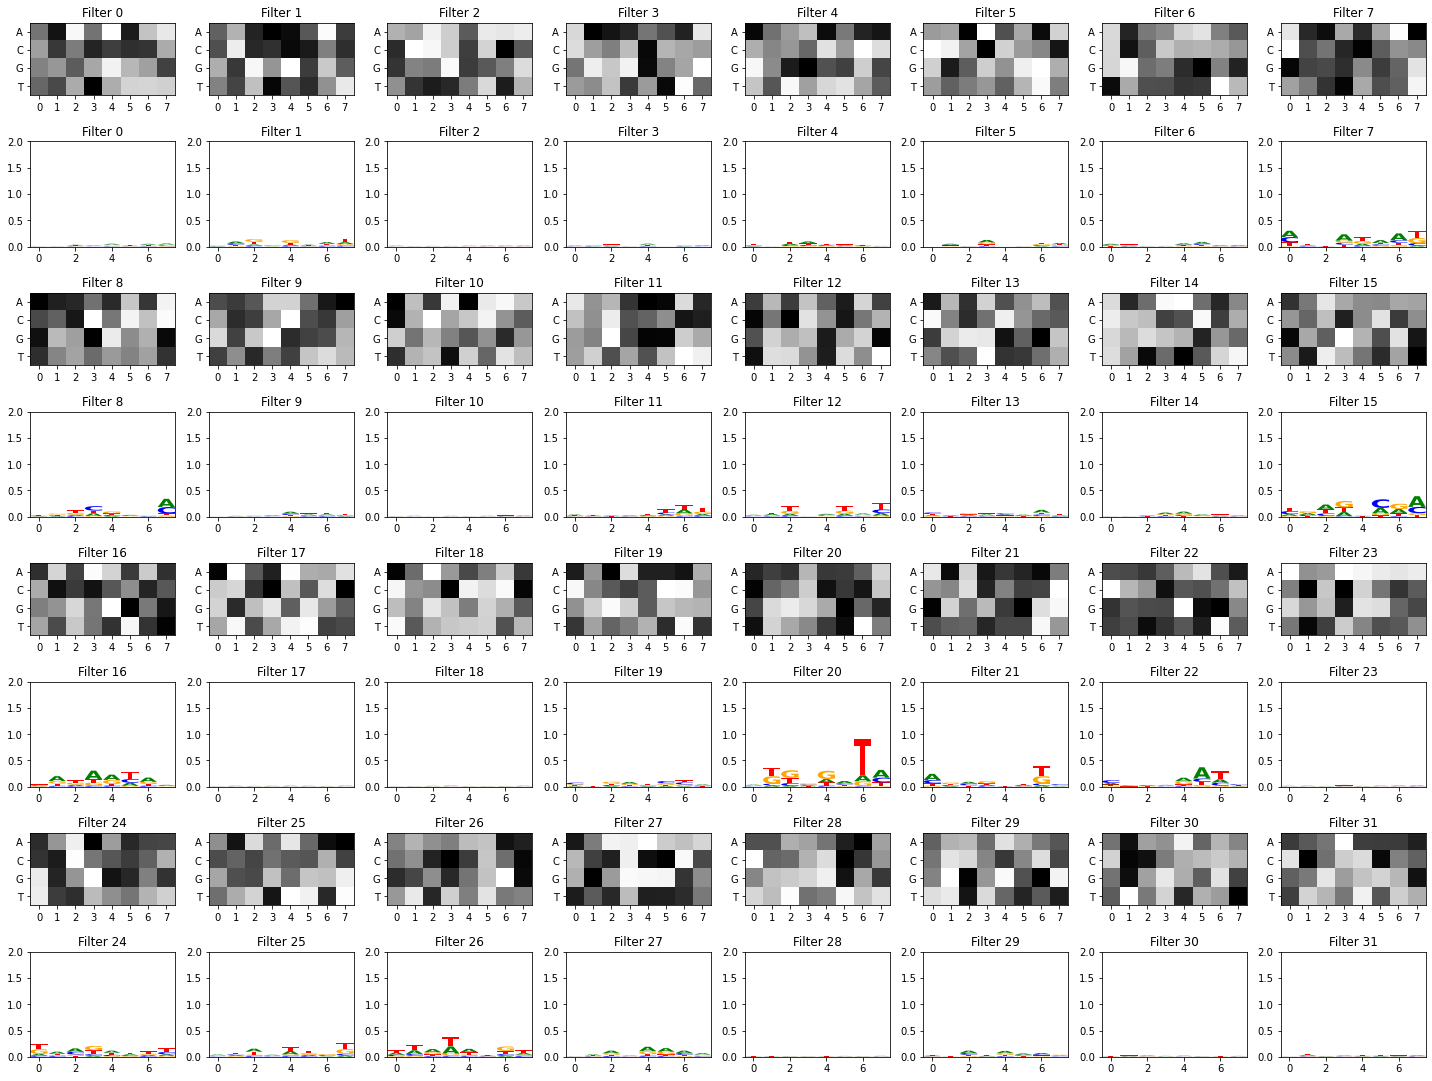

In [102]:
view_filters_and_logos(model_weights,filter_activations)

## sometimes the CNN filter viz's all come back empty... like none of them activated for anything? Again, wondering if just cuz teh model's still bad?

In [182]:
train_df.shape

(3370, 6)

In [183]:
test_df.shape

(843, 6)

In [185]:
model_weights[0][27]

tensor([[[-0.1794,  0.0953, -0.2002,  0.0588,  0.0695, -0.1782, -0.0438,
          -0.0335],
         [-0.1917,  0.0448,  0.1006,  0.0929,  0.0761,  0.0101, -0.0158,
          -0.1172],
         [-0.1809, -0.0006, -0.0227, -0.0439, -0.0407,  0.0446, -0.0785,
          -0.0912],
         [-0.0778,  0.0060, -0.0629,  0.0827,  0.0830, -0.1064, -0.1765,
           0.1022]]], grad_fn=<SelectBackward>)

In [186]:
model_weights[0][25]

tensor([[[-0.0508,  0.0493, -0.1441, -0.0237, -0.0729, -0.0629,  0.0721,
          -0.0183],
         [-0.1413,  0.0902, -0.1610,  0.0982,  0.0048, -0.1820,  0.0345,
          -0.1316],
         [-0.0169,  0.0728,  0.0050, -0.1994, -0.0062,  0.0392,  0.1323,
           0.0744],
         [-0.0877, -0.1330,  0.0371,  0.0317,  0.0451, -0.0488,  0.0691,
          -0.2035]]], grad_fn=<SelectBackward>)

In [187]:
filter_activations

{0: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 2: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.]]),
 3: tensor([[ 4224.,  3994.,  6990.,  9101.,  9793., 10234.,  1474., 10200.],
         [  844.,  1726.,   713.,  4357.,   258.,  1112.,  3683.,  7050.],
         [ 5046.,   526.,   877.,  2997.,  5015.,  6342., 14084.,  1244.],
         [10090., 13958., 11624.,  3749.,  5138.,  2516.,   963.,  1710.]]),
 4: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.

In [151]:
s = "CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT"
cv = conv_layers[0]
res = get_conv_output_for_seq(s, cv)

Running seq CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATAGTGGCATAATTTTTTTATAATATCATCTATTTACTCTTCGCTACCTTCTTAAAT


In [154]:
res[0]

tensor([[ -9.5746,  -9.4924,  -7.4644, -12.4131,  -9.3766, -12.4773,  -9.3960,
          -8.9915, -10.0036, -15.8174, -11.0617,  -9.1470, -11.6671,  -8.2978,
          -9.1411, -10.9788,  -9.1689,  -7.6458, -11.4770,  -7.7633,  -9.7536,
         -10.8268,  -8.3790,  -7.6119, -13.8003,  -9.7148, -10.7128,  -8.9994,
          -7.5161, -13.8485, -12.9574,  -8.7443,  -9.2733, -10.6395,  -8.6432,
         -12.2618, -10.2630, -11.1075,  -9.0176, -11.4900, -10.3899, -10.3149,
          -7.0597, -10.3635,  -8.5172, -12.8237, -10.7684, -10.5156, -12.9519,
         -11.4428,  -9.7300, -12.1845, -10.0502, -11.3992, -12.7044,  -9.2162,
         -13.7563,  -9.9278, -11.3679, -14.1289,  -9.6785, -12.0439, -10.7103,
          -8.0766, -13.5071, -10.9650, -10.9746,  -9.5969, -11.9218, -11.2454,
         -11.9609,  -7.3080, -11.2955, -11.3575, -10.6775, -11.5281, -11.9792,
          -7.2860,  -9.5770,  -8.8040, -10.6820,  -9.2874, -10.4569,  -9.5704,
          -9.8257, -10.7843,  -9.3882, -10.3675, -10

### Ok this seems to be running. The loss is exploding upward. Not yet sure if that's because it's a terrible model or if I've done something incorrectly. TBD

Or maybe it's the outlier loss issue coming back to bite us already!

# misc old stuff

In [11]:
def format_XY_dfs(tpm_df, meta_df):
    # melt tpm df so every sample is in a row
    tpm_melt = tpm_df[['locus_tag']+samples].melt(id_vars=['locus_tag'],var_name='sample',value_name='tpm')
    tpm_melt['condition'] = tpm_melt['sample'].apply(lambda x: sample2condition[x])

    # also add in upstream seq
    tpm_melt['upstream_region'] = tpm_melt['locus_tag'].apply(lambda x: loc2seq[x])
    
    # get coded metadata conditions from meta_df
    samp2cond_df = meta_df[['sample']+COND_COLS]

    # merge back onto the tpm df
    df = tpm_melt.merge(samp2cond_df,on='sample',how='left')
    
    # reformat full df
    full_df = df[['locus_tag','upstream_region', 'sample','condition']+COND_COLS+['tpm']]
    
    # separate out just X (features) and Y (labels)
    X = full_df[['locus_tag','upstream_region']+COND_COLS]
    Y = full_df['tpm']
    
    return full_df,X,Y

In [12]:
full_df, X, Y = format_XY_dfs(tpm_df,meta_df)
full_df.head()

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728


In [13]:
tpm_df.head()

,locus_tag,product,type,gene_symbol,locus,start_coord,end_coord,note,translation,gene_len,...,5GB1_pA9_red_tpm,5GB1_pA9_yellow_tpm,5GB1C-5G-La-BR1_tpm,5GB1C-5G-La-BR2_tpm,5GB1C-5G-N-BR1_tpm,5GB1C-5G-N-BR2_tpm,5GB1C-JG15-La-BR1_tpm,5GB1C-JG15-La-BR2_tpm,5GB1C-JG15-N-BR1_tpm,5GB1C-JG15-N-BR2_tpm
0,EQU24_RS00005,chromosomal replication initiator protein DnaA,CDS,dnaA,NZ_CP035467.1,0,1317,Derived by automated computational analysis us...,MSALWNNCLAKLENEISSSEFSTWIRPLQAIETDGQIKLLAPNRFV...,1318,...,38.557373,38.810668,37.444214,40.246006,40.100118,33.432274,39.880174,38.355431,30.247582,41.248441
1,EQU24_RS00010,DNA polymerase III subunit beta,CDS,,NZ_CP035467.1,1502,2603,Derived by automated computational analysis us...,MKYIINREQLLVPLQQIVSVIEKRQTMPILSNVLMVFRENTLVMTG...,1102,...,52.552767,52.461746,42.676553,49.210083,46.798476,48.142385,45.465136,46.498139,37.152951,52.902410
2,EQU24_RS00015,DNA replication/repair protein RecF,CDS,recF,NZ_CP035467.1,3060,4140,Derived by automated computational analysis us...,MSLQKLDIFNVRNIRQASLQPSPGLNLIYGANASGKSSVLEAIFIL...,1081,...,31.350991,34.914128,21.479309,24.204682,22.171104,22.006566,22.658157,22.753325,19.407103,29.834124
3,EQU24_RS00020,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,gyrB,NZ_CP035467.1,4185,6600,Derived by automated computational analysis us...,MSENIKQYDSTNIQVLKGLDAVRKRPGMYIGDTDDGTGLHHMVFEV...,2416,...,74.848501,80.850761,54.959319,64.911376,59.653059,64.648318,69.119079,65.643179,57.590223,68.306759
4,EQU24_RS00025,hypothetical protein,CDS,,NZ_CP035467.1,6825,7062,Derived by automated computational analysis us...,VKTTKYFLTTRMRPDREIIKDEWIQYVVRFPENEHIQFDGRIRRWA...,238,...,50.324948,49.349547,34.539657,36.521074,37.789611,39.358066,38.992158,35.870964,41.462392,40.227192


In [15]:
full_df.head()

,locus_tag,upstream_region,sample,condition,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode,tpm
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,2.933003
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.607784
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.415515
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,3.200081
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,5GB1_ferm_Ack_QC_tpm,lowO2_slow_growth,2,0,0,3,0,0,0,1.522728


In [18]:
len(X.upstream_region.values[0])

100

In [20]:
X

,locus_tag,upstream_region,carbon_source,oxygen_level,nitrate_level,copper_level,lanthanum_level,growth_rate,growth_mode
0,EQU24_RS00005,CGCCGGTTTATGTCAATTATGCCGGCACTGATTTGATTGCTGTATA...,2,0,0,3,0,0,0
1,EQU24_RS00010,AACGCCGGTTTTACAGTTCATAAGCTATTGATAAATAAAATAAAAA...,2,0,0,3,0,0,0
2,EQU24_RS00015,ATCGCAGTCATTATTAAATGTGGAAGCAACAAAAAAACGAGCTTGT...,2,0,0,3,0,0,0
3,EQU24_RS00020,AACTTAATAACTATAAAATGTTCCACGTGGAACATGGTGAAATTAA...,2,0,0,3,0,0,0
4,EQU24_RS00025,CTTTGCCGAACACCCCGCACCTCCACGCGTCAACAACGAAATTTGA...,2,0,0,3,0,0,0
...,...,...,...,...,...,...,...,...,...
412869,EQU24_RS22135,CCCGGCCGGTTTGGTCTTGTACTGGGTGGTCAACAATACGCTGTCG...,2,1,0,3,0,2,1
412870,EQU24_RS22140,GCCGCCCAGGGCACCTATCTTACAGTCCGAAGAGTATTAAAGTGTC...,2,1,0,3,0,2,1
412871,EQU24_RS22145,AATATTGATGTTGTTGTTATGGCCCGAAAAGATGCACTCAATGCAT...,2,1,0,3,0,2,1
412872,EQU24_RS22150,AAGAACTCACGGCTTTCGTGCCAGAATGGCGACCAAAGGCGGCCGT...,2,1,0,3,0,2,1


## Linear model arch

In [ ]:
class DNA_Linear(nn.Module):
    def __init__(self, seq_len,h1_size,num_heads):
        super().__init__()
        self.lin = nn.Linear(4*seq_len, h1_size)

    def forward(self, xb):
        # Linear wraps up the weights/bias dot product operations
        return self.lin(xb)